# 對ptt房屋版的房價議題進行情緒分析 (第八組)

# 動機
隨著即將踏入職場，房價成為我們關注的重點議題。  
為了更全面地了解市場情況，我們選擇 PTT 房屋版作為研究對象，透過情緒分析技術，了解網友對房市的討論與看法。  
我們希望藉由此專案，挖掘市場情緒趨勢，找出影響房價的關鍵因素，並為未來的房屋決策提供數據支持。 

引入套件

In [1]:
# 會用到的套件
import pandas as pd
import jieba
import jieba.analyse
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import cn2an

繪圖相關設定

In [2]:
from matplotlib import font_manager
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 
#plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # Windows 中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] # MacOS 內建中文字體

# 設定文字雲中文字體路徑
fontPath = 'raw_data/SourceHanSansTW-Regular.otf' # 設定字型
fprop = font_manager.FontProperties(fname=fontPath)  # 載入字型

### 資料介紹
資料來源：
+ TarFlow 蒐集PTT 房屋版 文章
+ 關鍵字：房價
+ 時間： 2024-03-01 ~ 2025-3-01
+ 資料筆數：共 5195 篇文章

讀取ptt檔案ptt_house_price.csv

In [3]:
df = pd.read_csv('raw_data/ptt_house_price.csv')
df.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/home-sale/M.1709249161....   
1          2  https://www.ptt.cc/bbs/home-sale/M.1709251729....   
2          3  https://www.ptt.cc/bbs/home-sale/M.1709255830....   
3          4  https://www.ptt.cc/bbs/home-sale/M.1709260904....   
4          5  https://www.ptt.cc/bbs/home-sale/M.1709263369....   

                 artTitle              artDate     artPoster artCatagory  \
0  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  2024-03-01 07:25:58      jump0517   home_sale   
1             [情報]好房網2月房價  2024-03-01 08:08:47  linlinme5208   home_sale   
2          Re:[情報]好房網2月房價  2024-03-01 09:17:08  junior020486   home_sale   
3    [閒聊]基隆是台北之外最不可能蓋GG的嗎  2024-03-01 10:41:42     Austenite   home_sale   
4             [請益]預售屋可否負擔  2024-03-01 11:22:47       mosfets   home_sale   

                                          artContent  \
0  連結：\nhttps://money.udn.com/money/story/5621/78...   
1  好房網 重點縣市成交漲跌排行\nhttps://price.housefun.com.tw/...   
2  你們那個要買新竹熱區的手腳要快\n新竹現在很誇張\n外圍補漲的很兇\n前幾天星XX超開價成交...   
3  最近各縣市都被點名要蓋GG\n高雄 台中 嘉義 虎尾\n被點名出列的房價都開始漲\n\n基隆...   
4  各位前輩好\n\n小弟目前在竹科工作 覺得新竹房價越來越高 因為工作快三年 有些自備款 有想...   

                                          artComment            e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "fatpigbgman"...    1.168.65.178   
1  [{"cmtStatus": "推", "cmtPoster": "ChennBZ", "c...  211.20.144.117   
2  [{"cmtStatus": "推", "cmtPoster": "hellogym", "...   49.216.24.218   
3  [{"cmtStatus": "推", "cmtPoster": "wwrest", "cm...     1.163.246.7   
4  [{"cmtStatus": "推", "cmtPoster": "JohnLackey",...      39.9.32.99   

          insertedDate dataSource  
0  2024-03-02 01:42:37        ptt  
1  2024-03-02 01:42:37        ptt  
2  2024-03-02 01:42:37        ptt  
3  2024-03-02 01:42:37        ptt  
4  2024-03-02 01:42:37        ptt

### 資料初步清理
- 清除內文為空值的文章

- 透過觀察發現ptt的文章常用兩個換行符號作為句子的結尾，因此將兩個換行取代為句號。

- 清除不重要的字如換行、網址

參考範例程式碼

In [4]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'] # 保留'artUrl'
clear_df.drop(drop_cols, axis = 1, inplace = True) # 若inplace=False會回傳新的Dataframe，需要賦值接它

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head(10)

artUrl  \
0  https://www.ptt.cc/bbs/home-sale/M.1709249161....   
1  https://www.ptt.cc/bbs/home-sale/M.1709251729....   
2  https://www.ptt.cc/bbs/home-sale/M.1709255830....   
3  https://www.ptt.cc/bbs/home-sale/M.1709260904....   
4  https://www.ptt.cc/bbs/home-sale/M.1709263369....   
5  https://www.ptt.cc/bbs/home-sale/M.1709265008....   
6  https://www.ptt.cc/bbs/home-sale/M.1709265534....   
7  https://www.ptt.cc/bbs/home-sale/M.1709267197....   
8  https://www.ptt.cc/bbs/home-sale/M.1709272677....   
9  https://www.ptt.cc/bbs/home-sale/M.1709281716....   

                     artTitle              artDate  \
0      [新聞]台灣金聯：土地未運用有原因駁斥養地炒  2024-03-01 07:25:58   
1                 [情報]好房網2月房價  2024-03-01 08:08:47   
2              Re:[情報]好房網2月房價  2024-03-01 09:17:08   
3        [閒聊]基隆是台北之外最不可能蓋GG的嗎  2024-03-01 10:41:42   
4                 [請益]預售屋可否負擔  2024-03-01 11:22:47   
5               [請益]建議用二胎房貸嗎？  2024-03-01 11:50:06   
6     [新聞]小坪數買氣夯？全台「小宅」驚人空屋率曝  2024-03-01 11:58:52   
7              [請益]掛4買第三間是否可行  2024-03-01 12:26:34   
8  [新聞]月收72K想買988萬新成屋　過來人警1事：  2024-03-01 13:57:55   
9          [請益]政府機關大樓對週邊房市的影響  2024-03-01 16:28:34   

                                          artContent  \
0  連結：\nhttps://money.udn.com/money/story/5621/78...   
1  好房網 重點縣市成交漲跌排行\nhttps://price.housefun.com.tw/...   
2  你們那個要買新竹熱區的手腳要快\n新竹現在很誇張\n外圍補漲的很兇\n前幾天星XX超開價成交...   
3  最近各縣市都被點名要蓋GG\n高雄 台中 嘉義 虎尾\n被點名出列的房價都開始漲\n\n基隆...   
4  各位前輩好\n\n小弟目前在竹科工作 覺得新竹房價越來越高 因為工作快三年 有些自備款 有想...   
5  是這樣的，我目前的房屋是在三年前買的\n\n使用 40 年房貸 / 寬限期 5 年\n\n目...   
6  小坪數買氣夯？全台「小宅」驚人空屋率曝光\n\nTVBS 記者 陳文越 / 攝影 鍾德榮 報...   
7  各位前輩好\n\n小弟目前在高雄工作 覺得高雄房價越來越高\n且這一波預售都還在漲，之後想必...   
8  連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...   
9  https://news.ltn.com.tw/amp/news/life/breaking...   

                                            sentence  
0  連結：， 駁斥養地炒房說。媒體報導，具公股色彩的台灣金聯近年大舉在南台灣與建商競標土地，得標...  
1  好房網 重點縣市成交漲跌排行， ->區域實價登錄趨勢。2024年。2月，重點縣市實價登錄漲跌...  
2  你們那個要買新竹熱區的手腳要快，新竹現在很誇張，外圍補漲的很兇，前幾天星XX超開價成交後，環...  
3  最近各縣市都被點名要蓋GG，高雄 台中 嘉義 虎尾，被點名出列的房價都開始漲。基隆484永遠...  
4  各位前輩好。小弟目前在竹科工作 覺得新竹房價越來越高 因為工作快三年 有些自備款 有想先上車...  
5  是這樣的，我目前的房屋是在三年前買的。使用 40 年房貸 / 寬限期 5 年。目前還在寬限期...  
6  小坪數買氣夯？全台「小宅」驚人空屋率曝光。TVBS 記者 陳文越 / 攝影 鍾德榮 報導。房...  
7  各位前輩好。小弟目前在高雄工作 覺得高雄房價越來越高，且這一波預售都還在漲，之後想必會把中古...  
8  連結：，　過來人警1事：房貸比房東無情。在眾多台灣年輕人面臨的生活議題中，「是否應該購房」一...  
9                         from MeowPtt on my iPhone。

【問題】接在網址後方的文字段落一併被移除，只剩下發送來源

範例程式碼處理後

In [5]:
clear_df.iloc[9]

artUrl        https://www.ptt.cc/bbs/home-sale/M.1709281716....
artTitle                                     [請益]政府機關大樓對週邊房市的影響
artDate                                     2024-03-01 16:28:34
artContent    https://news.ltn.com.tw/amp/news/life/breaking...
sentence                             from MeowPtt on my iPhone。
Name: 9, dtype: object

修正版

In [6]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'] # 保留'artUrl'
clear_df.drop(drop_cols, axis = 1, inplace = True) # 若inplace=False會回傳新的Dataframe，需要賦值接它

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，移除內文中的網址
clear_df['sentence'] = clear_df['artContent'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

#用'。'取代'\n\n'，用'，'取代'\n'
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)

clear_df.head(10)

artUrl  \
0  https://www.ptt.cc/bbs/home-sale/M.1709249161....   
1  https://www.ptt.cc/bbs/home-sale/M.1709251729....   
2  https://www.ptt.cc/bbs/home-sale/M.1709255830....   
3  https://www.ptt.cc/bbs/home-sale/M.1709260904....   
4  https://www.ptt.cc/bbs/home-sale/M.1709263369....   
5  https://www.ptt.cc/bbs/home-sale/M.1709265008....   
6  https://www.ptt.cc/bbs/home-sale/M.1709265534....   
7  https://www.ptt.cc/bbs/home-sale/M.1709267197....   
8  https://www.ptt.cc/bbs/home-sale/M.1709272677....   
9  https://www.ptt.cc/bbs/home-sale/M.1709281716....   

                     artTitle              artDate  \
0      [新聞]台灣金聯：土地未運用有原因駁斥養地炒  2024-03-01 07:25:58   
1                 [情報]好房網2月房價  2024-03-01 08:08:47   
2              Re:[情報]好房網2月房價  2024-03-01 09:17:08   
3        [閒聊]基隆是台北之外最不可能蓋GG的嗎  2024-03-01 10:41:42   
4                 [請益]預售屋可否負擔  2024-03-01 11:22:47   
5               [請益]建議用二胎房貸嗎？  2024-03-01 11:50:06   
6     [新聞]小坪數買氣夯？全台「小宅」驚人空屋率曝  2024-03-01 11:58:52   
7              [請益]掛4買第三間是否可行  2024-03-01 12:26:34   
8  [新聞]月收72K想買988萬新成屋　過來人警1事：  2024-03-01 13:57:55   
9          [請益]政府機關大樓對週邊房市的影響  2024-03-01 16:28:34   

                                          artContent  \
0  連結：\nhttps://money.udn.com/money/story/5621/78...   
1  好房網 重點縣市成交漲跌排行\nhttps://price.housefun.com.tw/...   
2  你們那個要買新竹熱區的手腳要快\n新竹現在很誇張\n外圍補漲的很兇\n前幾天星XX超開價成交...   
3  最近各縣市都被點名要蓋GG\n高雄 台中 嘉義 虎尾\n被點名出列的房價都開始漲\n\n基隆...   
4  各位前輩好\n\n小弟目前在竹科工作 覺得新竹房價越來越高 因為工作快三年 有些自備款 有想...   
5  是這樣的，我目前的房屋是在三年前買的\n\n使用 40 年房貸 / 寬限期 5 年\n\n目...   
6  小坪數買氣夯？全台「小宅」驚人空屋率曝光\n\nTVBS 記者 陳文越 / 攝影 鍾德榮 報...   
7  各位前輩好\n\n小弟目前在高雄工作 覺得高雄房價越來越高\n且這一波預售都還在漲，之後想必...   
8  連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...   
9  https://news.ltn.com.tw/amp/news/life/breaking...   

                                            sentence  
0  連結：。內文：。台灣金聯：土地未運用有原因 駁斥養地炒房說。媒體報導，具公股色彩的台灣金聯近...  
1  好房網 重點縣市成交漲跌排行。點選 ->區域實價登錄趨勢。2024年。2月，重點縣市實價登錄...  
2  你們那個要買新竹熱區的手腳要快，新竹現在很誇張，外圍補漲的很兇，前幾天星XX超開價成交後，環...  
3  最近各縣市都被點名要蓋GG，高雄 台中 嘉義 虎尾，被點名出列的房價都開始漲。基隆484永遠...  
4  各位前輩好。小弟目前在竹科工作 覺得新竹房價越來越高 因為工作快三年 有些自備款 有想先上車...  
5  是這樣的，我目前的房屋是在三年前買的。使用 40 年房貸 / 寬限期 5 年。目前還在寬限期...  
6  小坪數買氣夯？全台「小宅」驚人空屋率曝光。TVBS 記者 陳文越 / 攝影 鍾德榮 報導。房...  
7  各位前輩好。小弟目前在高雄工作 覺得高雄房價越來越高，且這一波預售都還在漲，之後想必會把中古...  
8  連結：。內文：月收72K想買988萬新成屋　過來人警1事：房貸比房東無情。在眾多台灣年輕人面...  
9  ，真心請益，除了施工期間對附近居民造成的不便之外，對於週邊的房價與租金行情大致會有什麼影響，...

原本範例程式碼先將\n換成逗號，\n\n換成句號，接著才做移除網址。  
導致正則表達式'http\S+'匹配不到換行符號，連帶將後面的字也一起移除。  
改變順序後:  
先做移除網址，才將\n換成逗號，\n\n換成句號，讓移除網址時可以讀到換行符號，就不會連後面的文字一同移除。  

修正程式碼順序後

In [7]:
clear_df.iloc[9]

artUrl        https://www.ptt.cc/bbs/home-sale/M.1709281716....
artTitle                                     [請益]政府機關大樓對週邊房市的影響
artDate                                     2024-03-01 16:28:34
artContent    https://news.ltn.com.tw/amp/news/life/breaking...
sentence      ，真心請益，除了施工期間對附近居民造成的不便之外，對於週邊的房價與租金行情大致會有什麼影響，...
Name: 9, dtype: object

### 斷句
中文主要以標點符號進行斷句，並清除空的字串

In [8]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df.head(10)

artUrl                artTitle  \
0  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
1  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
3  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
4  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
5  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
6  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
7  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
8  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
9  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   

               artDate                                         artContent  \
0  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
1  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
3  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
4  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
5  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
6  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
7  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
8  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
9  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   

                    sentence  
0                        連結：  
1                        內文：  
2      台灣金聯：土地未運用有原因 駁斥養地炒房說  
3                       媒體報導  
4  具公股色彩的台灣金聯近年大舉在南台灣與建商競標土地  
5                     得標後不開發  
6                          養  
7             放數年再加價轉售給建商賺價差  
8                   台灣金聯今天澄清  
9              絕不炒作房價也未曾炒作土地

### 斷詞
斷詞引擎設定：使用 Jieba 當作斷詞系統。

In [9]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
jieba.set_dictionary('dict/dict.txt')

斷詞前先將標點符號清除，並使用正規表達式清除空字串

In [10]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head(10)

artUrl                artTitle  \
0   https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
1   https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2   https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
3   https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
4   https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
5   https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
7   https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
8   https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
9   https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
11  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   

                artDate                                         artContent  \
0   2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
1   2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
2   2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
3   2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
4   2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
5   2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
7   2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
8   2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
9   2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
11  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   

                     sentence  
0                          連結  
1                          內文  
2        台灣金聯土地未運用有原因 駁斥養地炒房說  
3                        媒體報導  
4   具公股色彩的台灣金聯近年大舉在南台灣與建商競標土地  
5                      得標後不開發  
7              放數年再加價轉售給建商賺價差  
8                    台灣金聯今天澄清  
9               絕不炒作房價也未曾炒作土地  
11              地未運用是前期作業尚未完成

使用jieba進行斷詞

In [11]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

# 去除空值
word_df = word_df.dropna(subset=['word'])

word_df.head(10)

Building prefix dict from c:\Users\User\Desktop\2025-SMA-Study-Group-8\dict\dict.txt ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.uc44afc53f793310526f62d4cd650614b.cache
Loading model cost 0.272 seconds.
Prefix dict has been built successfully.


artUrl                artTitle  \
0  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
1  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   

               artDate                                         artContent word  
0  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   連結  
1  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   內文  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   台灣  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   金聯  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   土地  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...    未  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   運用  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...    有  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   原因  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...

#### 為了進行前後比較，先透過繪製詞頻圖及文字雲觀察一下目前的資料。

### 計算去除停用字及更新字典前的詞頻

In [12]:
freq_df = pd.DataFrame(word_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(10)

word  count
0    的  54811
1       47146
2    是  18762
3    有  12449
4    也  11645
5   房價  11478
6    了  11378
7    在  11079
8    都  11043
9    就  10244

### 4.6 視覺化結果

matplotlib 畫圖中文顯示不出來的問題

* Mac : <a href="https://blog.csdn.net/RivenDong/article/details/118990773">參考方式</a>
* Windows : <a href="https://medium.com/marketingdatascience/%E8%A7%A3%E6%B1%BApython-3-matplotlib%E8%88%87seaborn%E8%A6%96%E8%A6%BA%E5%8C%96%E5%A5%97%E4%BB%B6%E4%B8%AD%E6%96%87%E9%A1%AF%E7%A4%BA%E5%95%8F%E9%A1%8C-f7b3773a889b">參考方式</a>
* 暫存查找 path 方式：matplotlib.get_cachedir()

#### 繪製詞頻為前10高的長條圖

In [13]:
import matplotlib.font_manager as fm

font_path = "raw_data/NotoSansTC-Regular.ttf"
my_font = fm.FontProperties(fname=font_path)

# 手動將字體添加到 matplotlib 字體庫中
fm.fontManager.addfont(font_path)
# 設定 matplotlib 使用指定字體
plt.rcParams['font.family'] = my_font.get_name()

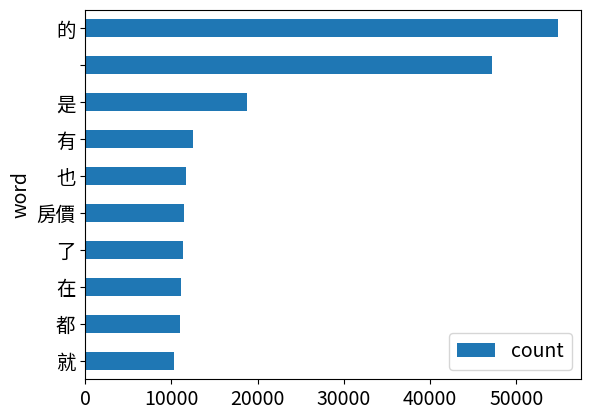

In [14]:
freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

#### 繪製文字雲

In [15]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count'] # 取得 count 對應的內部字典

print(dict(list(freq_dict.items())[:10]))

{'的': 54811, ' ': 47146, '是': 18762, '有': 12449, '也': 11645, '房價': 11478, '了': 11378, '在': 11079, '都': 11043, '就': 10244}


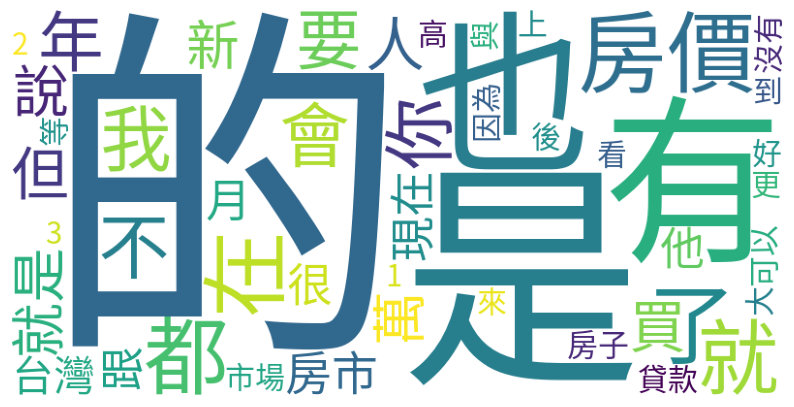

In [16]:
# 繪製文字雲
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400, font_path = fontPath, max_words = 50)
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

發現斷詞有許多一個字的結果，這些字對後續分析沒有意義，因此先去除斷詞結果少於兩個字的資料。

In [17]:
#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

計算詞頻並繪製長條圖

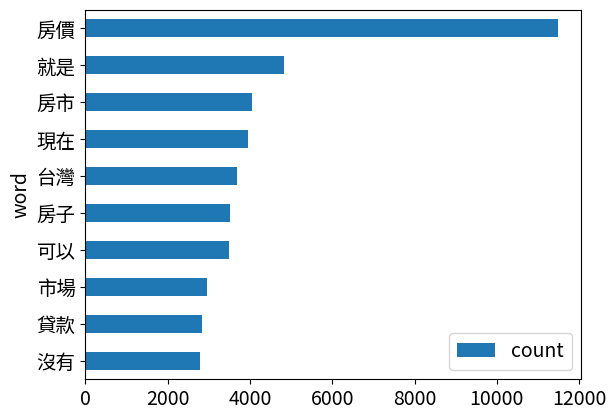

In [18]:
freq_df = pd.DataFrame(word_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()

freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()

plt.show()

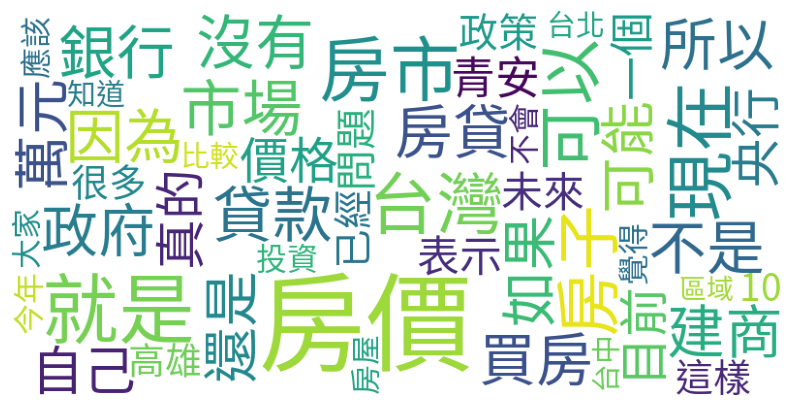

In [19]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

# 繪製文字雲
wordcloud_no1 = WordCloud(background_color = 'white', width = 800, height = 400, font_path = fontPath, max_words = 50)
wordcloud_no1.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_no1)
plt.axis('off')
plt.show()

### 移除停用字

目前資料中還是有許多對後續分析沒有幫助的無意義詞彙(停用字)，接下來會清除這些停用字。

In [20]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 

移除word欄位中的停用字

In [21]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]

noStop_df.head(10)

artUrl                artTitle  \
0  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
1  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   

               artDate                                         artContent word  
0  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   連結  
1  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   內文  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   台灣  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   金聯  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   土地  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   運用  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   原因  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   駁斥  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   養地  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   炒房

### 計算去除停用字後的詞頻

#### 再次繪製長條圖

C:\Users\User\AppData\Local\Temp\ipykernel_2468\583685406.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


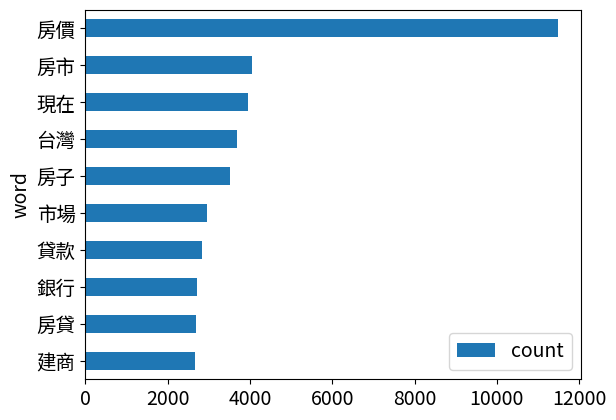

In [22]:
freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_nostop.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

#### 再次繪製文字雲

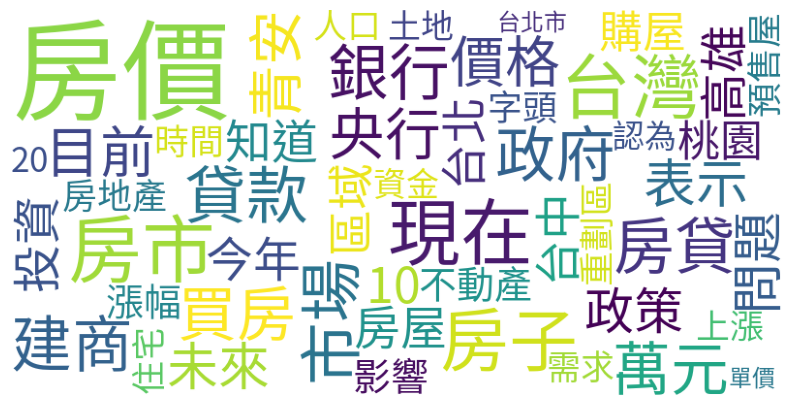

In [23]:
freq_dict_nostop = freq_df_nostop.set_index('word').to_dict()
freq_dict_nostop = freq_dict_nostop['count']

# 繪製文字雲
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = fontPath, max_words = 50)
wordcloud_nostop.generate_from_frequencies(freq_dict_nostop)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

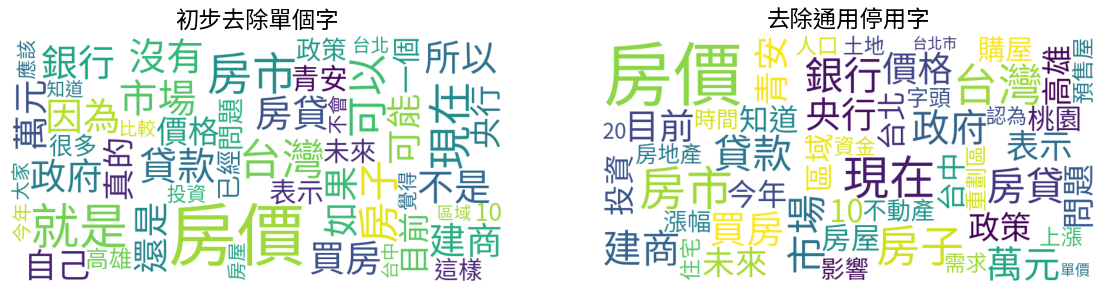

In [24]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud_no1)
plt.axis('off')
plt.title("初步去除單個字")

plt.subplot(1,2,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除通用停用字")

plt.show()

比較原本的文字雲，可以發現像如果、不是、因為...這類的通用停用字已被去除，然而，還有些未存在通用停用字字典內且對後續分析沒有幫助的詞彙，因此以下將以手動方式來去除這些詞彙。

### 更新停用字字典
去除完通用停用字後，還是發現到有一些對文字雲分析較無幫助的詞彙，如:今年、現在、知道...
</br>我們將這些詞彙用手動的方式加入停用字字典，並比較去除後的結果。

In [25]:
# 手動加入停用字
stopwords_manual = ["今年", "去年", "近年", "數年", "每年", "半年", "連結", "現在", "目前", "認為", "持續", "一直", "時間", "這種", "表示", "看到", 
                    "知道", "字頭", "根本", "地方", "平均", "區域", "價格", "一堆", "指出", "直接", "萬坪"] 
stopwords.extend(stopwords_manual)

In [26]:
# 去除停用字
noStop_df_2 = noStop_df[~noStop_df['word'].isin(stopwords)]
noStop_df_2.head(10)

artUrl                artTitle  \
1  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
3  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   

               artDate                                         artContent word  
1  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   內文  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   台灣  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   金聯  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   土地  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   運用  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   原因  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   駁斥  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   養地  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   炒房  
3  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   媒體

#### 再次繪製文字雲

C:\Users\User\AppData\Local\Temp\ipykernel_2468\3623548723.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop_2 = pd.DataFrame(pd.value_counts(noStop_df_2['word'])).sort_values(by = ['count'], ascending = False).reset_index()


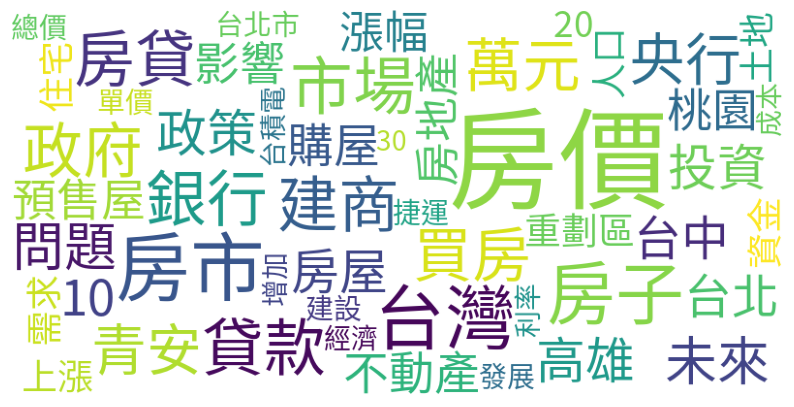

In [27]:
# 計算詞頻
freq_df_nostop_2 = pd.DataFrame(pd.value_counts(noStop_df_2['word'])).sort_values(by = ['count'], ascending = False).reset_index()

# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict_nostop_2 = freq_df_nostop_2.set_index('word').to_dict()
freq_dict_nostop_2 = freq_dict_nostop_2['count']

# 繪製文字雲
wordcloud_nostop_2 = WordCloud(background_color = 'white', width = 800, height = 400, font_path = fontPath, max_words = 50)
wordcloud_nostop_2.generate_from_frequencies(freq_dict_nostop_2)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop_2)
plt.axis('off')
plt.show()

透過文字雲看一下目前為止做的文字處理結果有什麼差異

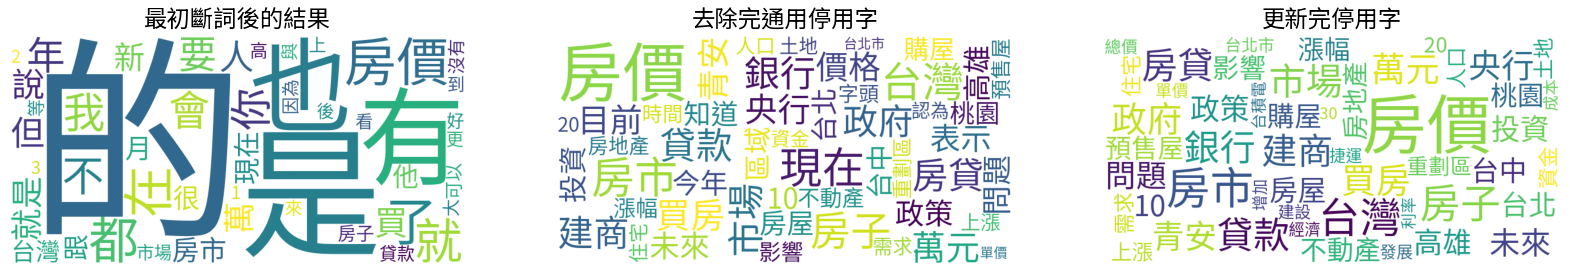

In [28]:
plt.figure(figsize = (20,14))

plt.subplot(1,3,1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("最初斷詞後的結果")

plt.subplot(1,3,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除完通用停用字")

plt.subplot(1,3,3)
plt.imshow(wordcloud_nostop_2)
plt.axis('off')
plt.title("更新完停用字")

plt.show()

可以發現再進一步更新完停用字後，文字雲已正確去除我們手動加入的停用字，然而還存在一些組合字問題，如:萬元、年、坪...

### 更新斷詞字典

"萬元"、"年"、"坪"前面會有數字或文字，形成組合詞，如:30萬元、三十坪...

In [29]:
# 自動提取所有數字/文字 + 萬元 的詞並加入jieba斷詞字典
sent_df2 = sent_df.copy()

# 正則表達式匹配
pattern = r'([\d零一二三四五六七八九十百千萬億]+萬元)'
pattern2 = r'([\d零一二三四五六七八九十百]+年)'
pattern3 = r'([\d零一二三四五六七八九十百]+坪)'

# 找出所有符合條件的詞，並存入 set（除去重複詞）
# .sum() -> 把apply()的結果展開
custom_words = set(sent_df2["sentence"]
                   .apply(lambda x: re.findall(pattern, x))
                   .sum()).union(set(sent_df2["sentence"].apply(lambda x: re.findall(pattern2, x)).sum())).union(set(sent_df2["sentence"].apply(lambda x: re.findall(pattern3, x)).sum()))

# 存入斷詞字典
for word in custom_words:
    jieba.add_word(word)

重新進行斷詞及清除停用字

In [30]:
# sent_df是還沒斷詞過的df
word_df_updated = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#把長度小於1的row刪掉
word_df_updated = word_df_updated.loc[word_df_updated['word'].str.len()>1]

#去除停用字
nostop_df_updated = word_df_updated[~word_df_updated['word'].isin(stopwords)]

nostop_df_updated.head()

artUrl                artTitle  \
1  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   

               artDate                                         artContent word  
1  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   內文  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   台灣  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   金聯  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   土地  
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   運用

檢查"萬元"的前面有沒有匹配到數字或文字

In [31]:
num_wanyuan = nostop_df_updated[nostop_df_updated["word"].str.contains("萬元", na=False)]
num_wanyuan.head()

artUrl  \
379  https://www.ptt.cc/bbs/home-sale/M.1709272677....   
386  https://www.ptt.cc/bbs/home-sale/M.1709272677....   
387  https://www.ptt.cc/bbs/home-sale/M.1709272677....   
390  https://www.ptt.cc/bbs/home-sale/M.1709272677....   
391  https://www.ptt.cc/bbs/home-sale/M.1709272677....   

                       artTitle              artDate  \
379  [新聞]月收72K想買988萬新成屋　過來人警1事：  2024-03-01 13:57:55   
386  [新聞]月收72K想買988萬新成屋　過來人警1事：  2024-03-01 13:57:55   
387  [新聞]月收72K想買988萬新成屋　過來人警1事：  2024-03-01 13:57:55   
390  [新聞]月收72K想買988萬新成屋　過來人警1事：  2024-03-01 13:57:55   
391  [新聞]月收72K想買988萬新成屋　過來人警1事：  2024-03-01 13:57:55   

                                            artContent   word  
379  連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...    百萬元  
386  連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...    百萬元  
387  連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...    4萬元  
390  連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...   50萬元  
391  連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...  988萬元

檢查"年"的前面有沒有匹配到數字或文字

In [32]:
num_year = nostop_df_updated[nostop_df_updated["word"].str.contains("年", na=False)]
num_year.head()

artUrl                artTitle  \
45  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
65  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
86  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
90  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
96  https://www.ptt.cc/bbs/home-sale/M.1709251729....             [情報]好房網2月房價   

                artDate                                         artContent  \
45  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
65  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
86  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
90  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
96  2024-03-01 08:08:47  好房網 重點縣市成交漲跌排行\nhttps://price.housefun.com.tw/...   

     word  
45     3年  
65     年度  
86    14年  
90    前幾年  
96  2024年

檢查"坪"的前面有沒有匹配到數字或文字

In [33]:
num_ground = nostop_df_updated[nostop_df_updated["word"].str.contains("坪", na=False)]
num_ground.head()

artUrl  \
39   https://www.ptt.cc/bbs/home-sale/M.1709249161....   
40   https://www.ptt.cc/bbs/home-sale/M.1709249161....   
42   https://www.ptt.cc/bbs/home-sale/M.1709249161....   
150  https://www.ptt.cc/bbs/home-sale/M.1709255830....   
208  https://www.ptt.cc/bbs/home-sale/M.1709265534....   

                    artTitle              artDate  \
39    [新聞]台灣金聯：土地未運用有原因駁斥養地炒  2024-03-01 07:25:58   
40    [新聞]台灣金聯：土地未運用有原因駁斥養地炒  2024-03-01 07:25:58   
42    [新聞]台灣金聯：土地未運用有原因駁斥養地炒  2024-03-01 07:25:58   
150           Re:[情報]好房網2月房價  2024-03-01 09:17:08   
208  [新聞]小坪數買氣夯？全台「小宅」驚人空屋率曝  2024-03-01 11:58:52   

                                            artContent  word  
39   連結：\nhttps://money.udn.com/money/story/5621/78...  176坪  
40   連結：\nhttps://money.udn.com/money/story/5621/78...   85坪  
42   連結：\nhttps://money.udn.com/money/story/5621/78...  261坪  
150  你們那個要買新竹熱區的手腳要快\n新竹現在很誇張\n外圍補漲的很兇\n前幾天星XX超開價成交...    一坪  
208  小坪數買氣夯？全台「小宅」驚人空屋率曝光\n\nTVBS 記者 陳文越 / 攝影 鍾德榮 報...    坪數

數字格式統一：阿拉伯數字轉成中文數字

In [34]:
nostop_df_updated["word"] = nostop_df_updated["word"].apply(lambda x: cn2an.transform(x, "an2cn"))

# 檢查阿拉伯數字有無正確轉換成中文
nostop_df_updated[nostop_df_updated["word"].str.contains("坪", na=False)].head()

c:\Users\User\anaconda3\envs\sa\Lib\site-packages\cn2an\transform.py:103: UserWarning: 超出数据范围，最长支持 16 位
  warn(str(e))
C:\Users\User\AppData\Local\Temp\ipykernel_2468\1316863311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nostop_df_updated["word"] = nostop_df_updated["word"].apply(lambda x: cn2an.transform(x, "an2cn"))


artUrl  \
39   https://www.ptt.cc/bbs/home-sale/M.1709249161....   
40   https://www.ptt.cc/bbs/home-sale/M.1709249161....   
42   https://www.ptt.cc/bbs/home-sale/M.1709249161....   
150  https://www.ptt.cc/bbs/home-sale/M.1709255830....   
208  https://www.ptt.cc/bbs/home-sale/M.1709265534....   

                    artTitle              artDate  \
39    [新聞]台灣金聯：土地未運用有原因駁斥養地炒  2024-03-01 07:25:58   
40    [新聞]台灣金聯：土地未運用有原因駁斥養地炒  2024-03-01 07:25:58   
42    [新聞]台灣金聯：土地未運用有原因駁斥養地炒  2024-03-01 07:25:58   
150           Re:[情報]好房網2月房價  2024-03-01 09:17:08   
208  [新聞]小坪數買氣夯？全台「小宅」驚人空屋率曝  2024-03-01 11:58:52   

                                            artContent    word  
39   連結：\nhttps://money.udn.com/money/story/5621/78...  一百七十六坪  
40   連結：\nhttps://money.udn.com/money/story/5621/78...    八十五坪  
42   連結：\nhttps://money.udn.com/money/story/5621/78...  二百六十一坪  
150  你們那個要買新竹熱區的手腳要快\n新竹現在很誇張\n外圍補漲的很兇\n前幾天星XX超開價成交...      一坪  
208  小坪數買氣夯？全台「小宅」驚人空屋率曝光\n\nTVBS 記者 陳文越 / 攝影 鍾德榮 報...      坪數

#### 重新計算詞頻

In [35]:
freq_df_updated = pd.DataFrame(pd.value_counts(nostop_df_updated['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_updated.head(10)

C:\Users\User\AppData\Local\Temp\ipykernel_2468\1450957720.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_updated = pd.DataFrame(pd.value_counts(nostop_df_updated['word'])).sort_values(by = ['count'], ascending = False).reset_index()


word  count
0   房價  11478
1   房市   4062
2   台灣   3680
3   房子   3505
4   市場   2952
5   貸款   2846
6   銀行   2720
7   房貸   2688
8   建商   2669
9   政府   2620

#### 重新繪製詞頻長條圖

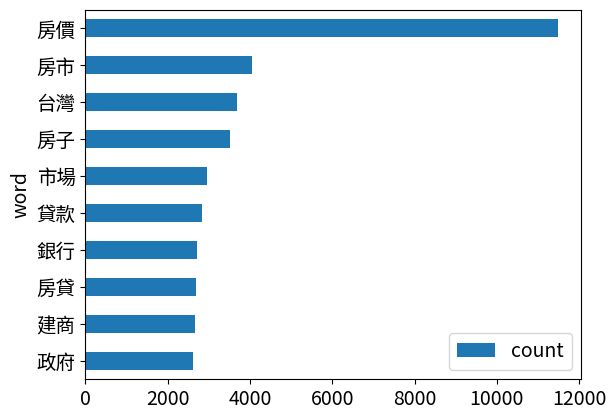

In [36]:
freq_df_updated.head(10).plot.barh(x='word', y='count').invert_yaxis()
plt.show()

#### 繪製文字雲

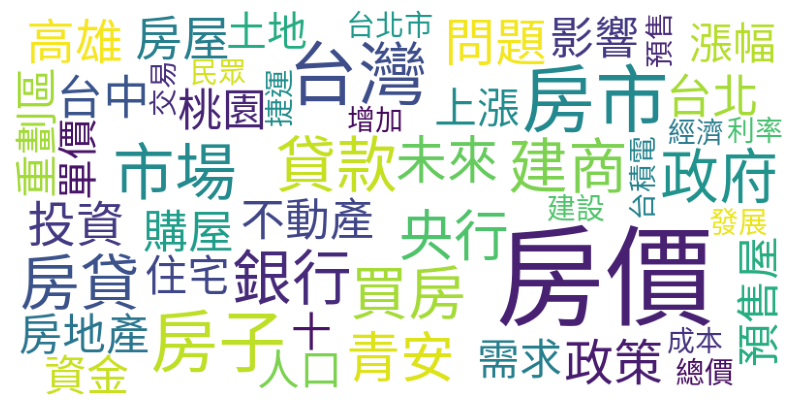

In [37]:
freq_dict_updated = freq_df_updated.set_index('word').to_dict()
freq_dict_updated = freq_dict_updated['count']

# 繪製文字雲
wordcloud_after = WordCloud(background_color='white', width=800, height = 400, font_path = fontPath, max_words = 50)
wordcloud_after.generate_from_frequencies(freq_dict_updated)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_after)
plt.axis('off')
plt.show()

### 4.10 比較清理前後的文字雲

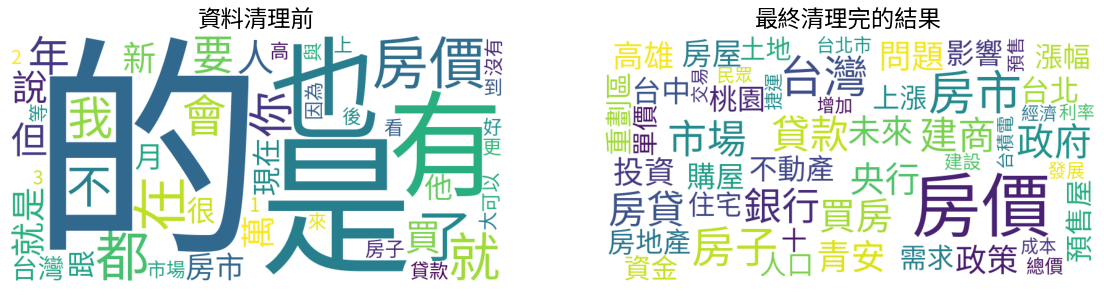

In [38]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("資料清理前")

plt.subplot(1,2,2)
plt.imshow(wordcloud_after)
plt.axis('off')
plt.title("最終清理完的結果")

plt.show()

儲存clean data，以便後續其他使用

In [39]:
nostop_df_updated.to_csv("raw_data/cleaned_ptt_house_price.csv", encoding = 'utf-8',index = False)

### 3. Lexicon-based 情緒分析

In [40]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

word sentiments
0   ):     affect
1   3q     affect
2   :(     affect
3   :)     affect
4   <3     affect

In [41]:
liwc_dict['sentiments'].describe()

count       4682
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

#### 3.2 情緒字典與斷詞結果進行合併

In [42]:
print(nostop_df_updated.columns)


Index(['artUrl', 'artTitle', 'artDate', 'artContent', 'word'], dtype='object')


移除時間

In [43]:
nostop_df_updated = pd.read_csv("raw_data/cleaned_ptt_house_price.csv", encoding="utf-8")
print(nostop_df_updated.columns)

# 切割日期與時間
nostop_df_updated["artDate"] = pd.to_datetime(nostop_df_updated["artDate"])  # 轉換為 datetime 格式
nostop_df_updated["artTime"] = nostop_df_updated["artDate"].dt.time  # 取出時間部分
nostop_df_updated["artDate"] = nostop_df_updated["artDate"].dt.date  # 取出日期部分
# 顯示切割後的結果
print(nostop_df_updated[["artDate", "artTime"]].head())

print(nostop_df_updated.columns)
# 存回 CSV
nostop_df_updated.to_csv("raw_data/cleaned_ptt_house_price_updated.csv", encoding="utf-8", index=False)

ptt_liwc_df = pd.merge(nostop_df_updated[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df.head()

Index(['artUrl', 'artTitle', 'artDate', 'artContent', 'word'], dtype='object')
      artDate   artTime
0  2024-03-01  07:25:58
1  2024-03-01  07:25:58
2  2024-03-01  07:25:58
3  2024-03-01  07:25:58
4  2024-03-01  07:25:58
Index(['artUrl', 'artTitle', 'artDate', 'artContent', 'word', 'artTime'], dtype='object')


artUrl     artDate  \
0  https://www.ptt.cc/bbs/home-sale/M.1709249161....  2024-03-01   
1  https://www.ptt.cc/bbs/home-sale/M.1709249161....  2024-03-01   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  2024-03-01   
3  https://www.ptt.cc/bbs/home-sale/M.1709249161....  2024-03-01   
4  https://www.ptt.cc/bbs/home-sale/M.1709249161....  2024-03-01   

                 artTitle                                         artContent  \
0  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  連結：\nhttps://money.udn.com/money/story/5621/78...   
1  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  連結：\nhttps://money.udn.com/money/story/5621/78...   
2  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  連結：\nhttps://money.udn.com/money/story/5621/78...   
3  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  連結：\nhttps://money.udn.com/money/story/5621/78...   
4  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  連結：\nhttps://money.udn.com/money/story/5621/78...   

  word sentiments  
0   內文        NaN  
1   台灣        NaN  
2   金聯        NaN  
3   土地        NaN  
4   運用        NaN

#### 3.3 正負向情緒詞彙頻率折線圖圖

In [44]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count.head(10)

artDate sentiments  size
3   2024-03-01   negative    33
4   2024-03-01   positive    41
8   2024-03-02   negative    18
9   2024-03-02   positive    30
14  2024-03-03   negative    21
15  2024-03-03   positive    28
20  2024-03-04   negative    40
21  2024-03-04   positive    58
27  2024-03-05   positive    63
26  2024-03-05   negative    47

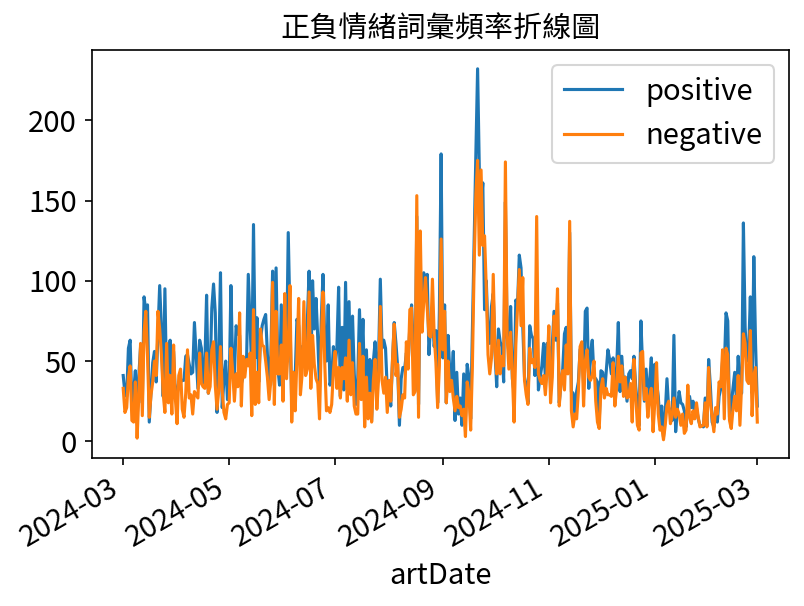

In [45]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
#fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

```Moving average```

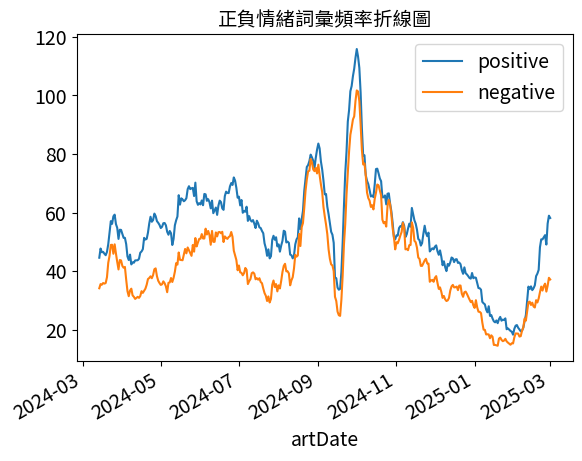

In [46]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

透過此圖可以看出此版討論很熱烈，正面負面的情緒詞彙的出現頻率差不多。

#### 3.4 正負向情緒詞彙比例折線圖圖

In [47]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count.head(10)

artDate sentiments  size     ratio
3   2024-03-01   negative    33  0.445946
4   2024-03-01   positive    41  0.554054
8   2024-03-02   negative    18  0.375000
9   2024-03-02   positive    30  0.625000
14  2024-03-03   negative    21  0.428571
15  2024-03-03   positive    28  0.571429
20  2024-03-04   negative    40  0.408163
21  2024-03-04   positive    58  0.591837
27  2024-03-05   positive    63  0.572727
26  2024-03-05   negative    47  0.427273

In [48]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

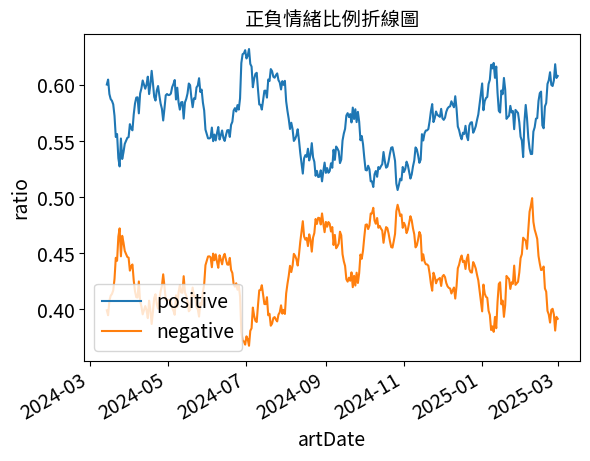

In [49]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)  # 記得加上才能顯示中文

#### 3.5 正負向情緒分數折線圖

In [50]:
sentiment_count.head(10)

artDate sentiments  size     ratio
3   2024-03-01   negative    33  0.445946
4   2024-03-01   positive    41  0.554054
8   2024-03-02   negative    18  0.375000
9   2024-03-02   positive    30  0.625000
14  2024-03-03   negative    21  0.428571
15  2024-03-03   positive    28  0.571429
20  2024-03-04   negative    40  0.408163
21  2024-03-04   positive    58  0.591837
27  2024-03-05   positive    63  0.572727
26  2024-03-05   negative    47  0.427273

In [51]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

artDate  negative  positive
0  2024-03-01      33.0      41.0
1  2024-03-02      18.0      30.0
2  2024-03-03      21.0      28.0
3  2024-03-04      40.0      58.0
4  2024-03-05      47.0      63.0

In [52]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

artDate  negative  positive  sentiment_value
0  2024-03-01      33.0      41.0              8.0
1  2024-03-02      18.0      30.0             12.0
2  2024-03-03      21.0      28.0              7.0
3  2024-03-04      40.0      58.0             18.0
4  2024-03-05      47.0      63.0             16.0

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

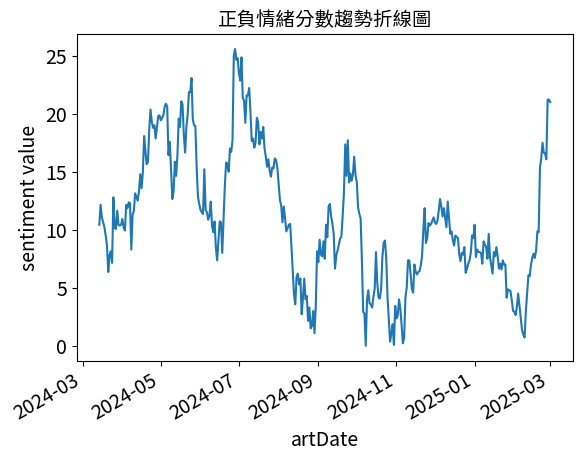

In [53]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文

#### 3.6 文章為單位的情緒分析

In [54]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article.head(10)

artUrl sentiments  size
0  https://www.ptt.cc/bbs/home-sale/M.1709249161....     affect     9
1  https://www.ptt.cc/bbs/home-sale/M.1709249161....      anger     2
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....   negative     2
3  https://www.ptt.cc/bbs/home-sale/M.1709249161....   positive     5
4  https://www.ptt.cc/bbs/home-sale/M.1709255830....     affect     1
5  https://www.ptt.cc/bbs/home-sale/M.1709255830....        anx     1
6  https://www.ptt.cc/bbs/home-sale/M.1709255830....   negative     1
7  https://www.ptt.cc/bbs/home-sale/M.1709255830....        sad     1
8  https://www.ptt.cc/bbs/home-sale/M.1709263369....     affect     2
9  https://www.ptt.cc/bbs/home-sale/M.1709263369....   negative     1

In [55]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/home-sale/M.1709249161....     9.0    2.0  0.0   
1  https://www.ptt.cc/bbs/home-sale/M.1709255830....     1.0    0.0  1.0   
2  https://www.ptt.cc/bbs/home-sale/M.1709263369....     2.0    0.0  0.0   
3  https://www.ptt.cc/bbs/home-sale/M.1709265008....     2.0    0.0  0.0   
4  https://www.ptt.cc/bbs/home-sale/M.1709265534....     7.0    0.0  0.0   

   negative  positive  sad  
0       2.0       5.0  0.0  
1       1.0       0.0  1.0  
2       1.0       1.0  0.0  
3       1.0       1.0  0.0  
4       5.0       5.0  1.0

In [56]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/home-sale/M.1709249161....     9.0    2.0  0.0   
1  https://www.ptt.cc/bbs/home-sale/M.1709255830....     1.0    0.0  1.0   
2  https://www.ptt.cc/bbs/home-sale/M.1709263369....     2.0    0.0  0.0   
3  https://www.ptt.cc/bbs/home-sale/M.1709265008....     2.0    0.0  0.0   
4  https://www.ptt.cc/bbs/home-sale/M.1709265534....     7.0    0.0  0.0   

   negative  positive  sad  sentiment_value  
0       2.0       5.0  0.0              3.0  
1       1.0       0.0  1.0             -1.0  
2       1.0       1.0  0.0              0.0  
3       1.0       1.0  0.0              0.0  
4       5.0       5.0  1.0              0.0

In [57]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article.head(10)

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/home-sale/M.1709249161....     9.0    2.0  0.0   
1  https://www.ptt.cc/bbs/home-sale/M.1709255830....     1.0    0.0  1.0   
2  https://www.ptt.cc/bbs/home-sale/M.1709263369....     2.0    0.0  0.0   
3  https://www.ptt.cc/bbs/home-sale/M.1709265008....     2.0    0.0  0.0   
4  https://www.ptt.cc/bbs/home-sale/M.1709265534....     7.0    0.0  0.0   
5  https://www.ptt.cc/bbs/home-sale/M.1709267197....     1.0    0.0  0.0   
6  https://www.ptt.cc/bbs/home-sale/M.1709272677....    24.0    3.0  3.0   
7  https://www.ptt.cc/bbs/home-sale/M.1709281716....     2.0    0.0  1.0   
8  https://www.ptt.cc/bbs/home-sale/M.1709289053....     7.0    0.0  0.0   
9  https://www.ptt.cc/bbs/home-sale/M.1709291599....    10.0    0.0  4.0   

   negative  positive  sad  sentiment_value sentiment_class  
0       2.0       5.0  0.0              3.0              正向  
1       1.0       0.0  1.0             -1.0              負向  
2       1.0       1.0  0.0              0.0              負向  
3       1.0       1.0  0.0              0.0              負向  
4       5.0       5.0  1.0              0.0              負向  
5       0.0       1.0  0.0              1.0              正向  
6      12.0       8.0  0.0             -4.0              負向  
7       1.0       0.0  0.0             -1.0              負向  
8       0.0       7.0  0.0              7.0              正向  
9       6.0       4.0  1.0             -2.0              負向

In [58]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date

clear_df_sentiment.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/home-sale/M.1709249161....   
1          2  https://www.ptt.cc/bbs/home-sale/M.1709251729....   
2          3  https://www.ptt.cc/bbs/home-sale/M.1709255830....   
3          4  https://www.ptt.cc/bbs/home-sale/M.1709260904....   
4          5  https://www.ptt.cc/bbs/home-sale/M.1709263369....   

                 artTitle     artDate     artPoster artCatagory  \
0  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  2024-03-01      jump0517   home_sale   
1             [情報]好房網2月房價  2024-03-01  linlinme5208   home_sale   
2          Re:[情報]好房網2月房價  2024-03-01  junior020486   home_sale   
3    [閒聊]基隆是台北之外最不可能蓋GG的嗎  2024-03-01     Austenite   home_sale   
4             [請益]預售屋可否負擔  2024-03-01       mosfets   home_sale   

                                          artContent  \
0  連結：\nhttps://money.udn.com/money/story/5621/78...   
1  好房網 重點縣市成交漲跌排行\nhttps://price.housefun.com.tw/...   
2  你們那個要買新竹熱區的手腳要快\n新竹現在很誇張\n外圍補漲的很兇\n前幾天星XX超開價成交...   
3  最近各縣市都被點名要蓋GG\n高雄 台中 嘉義 虎尾\n被點名出列的房價都開始漲\n\n基隆...   
4  各位前輩好\n\n小弟目前在竹科工作 覺得新竹房價越來越高 因為工作快三年 有些自備款 有想...   

                                          artComment            e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "fatpigbgman"...    1.168.65.178   
1  [{"cmtStatus": "推", "cmtPoster": "ChennBZ", "c...  211.20.144.117   
2  [{"cmtStatus": "推", "cmtPoster": "hellogym", "...   49.216.24.218   
3  [{"cmtStatus": "推", "cmtPoster": "wwrest", "cm...     1.163.246.7   
4  [{"cmtStatus": "推", "cmtPoster": "JohnLackey",...      39.9.32.99   

          insertedDate dataSource sentiment_class  
0  2024-03-02 01:42:37        ptt              正向  
1  2024-03-02 01:42:37        ptt             NaN  
2  2024-03-02 01:42:37        ptt              負向  
3  2024-03-02 01:42:37        ptt             NaN  
4  2024-03-02 01:42:37        ptt              負向

In [59]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

artDate sentiment_class  size
0    2024-03-01              正向     5
1    2024-03-01              負向     8
2    2024-03-02              正向     3
3    2024-03-02              負向     1
4    2024-03-03              正向     2
..          ...             ...   ...
714  2025-02-27              負向     6
715  2025-02-28              正向     5
716  2025-02-28              負向     8
717  2025-03-01              正向     4
718  2025-03-01              負向     3

[719 rows x 3 columns]

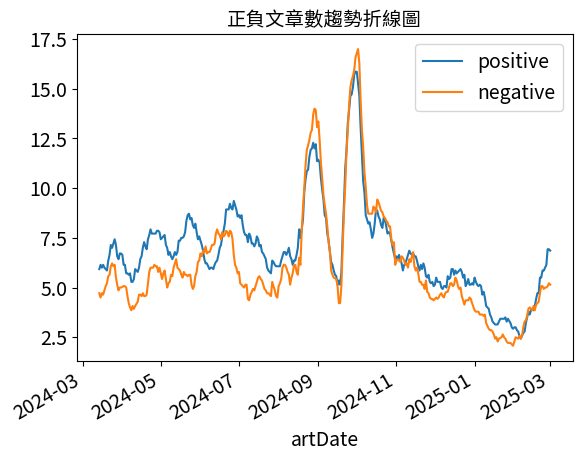

In [60]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

正面文章與負面文章的數量差不多，差不多在2024年9月-2024年11月討論度異常的高(用詞較情緒化)。

#### 情緒代表字

In [61]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()   
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_count.head(10)

word sentiments  size
572    問題   negative  1907
571    問題     affect  1907
2510   負擔   negative   651
2509   負擔     affect   651
889    希望   positive   648
888    希望     affect   648
2752   風險   negative   586
2750   風險     affect   586
2751   風險        anx   586
677    壓力   negative   559

In [62]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]      # 正向的情緒代表字
word_of_pos.head(15)

word sentiments  size
889    希望   positive   648
525    吸引   positive   503
2140   簡單   positive   433
2746   願意   positive   414
2647   重要   positive   400
834    容易   positive   396
197    信義   positive   386
505    合理   positive   370
590    喜歡   positive   354
1522   有錢   positive   346
1524   朋友   positive   335
341    分享   positive   328
275    優勢   positive   325
2429   解決   positive   319
1667   決定   positive   296

In [63]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]      # 負向的情緒代表字
word_of_neg.head(15)

word sentiments  size
572    問題   negative  1907
2510   負擔   negative   651
2752   風險   negative   586
677    壓力   negative   559
1404   擔心   negative   370
2683   降低   negative   331
635    嚴重   negative   279
2407   衝擊   negative   255
69     不足   negative   253
2700   隨便   negative   206
2771   驚人   negative   192
1288   抑制   negative   180
644    困難   negative   172
2206   缺點   negative   160
1240   戰爭   negative   155

C:\Users\User\AppData\Local\Temp\ipykernel_2468\1493987806.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\User\AppData\Local\Temp\ipykernel_2468\1493987806.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

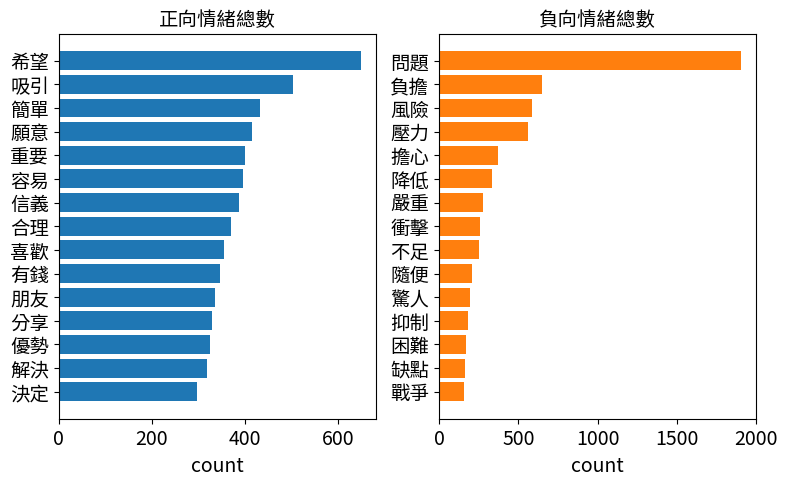

In [64]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2, figsize=(9,5))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

### 檢查情緒詞是否符合文本 

In [65]:
filtered_df = sent_df[sent_df['sentence'].str.contains('降低', na=False)]  
filtered_df.head()

artUrl  \
252   https://www.ptt.cc/bbs/home-sale/M.1709265534....   
567   https://www.ptt.cc/bbs/home-sale/M.1709291599....   
780   https://www.ptt.cc/bbs/home-sale/M.1709364873....   
1989  https://www.ptt.cc/bbs/home-sale/M.1709572735....   
2388  https://www.ptt.cc/bbs/home-sale/M.1709624526....   

                     artTitle              artDate  \
252   [新聞]小坪數買氣夯？全台「小宅」驚人空屋率曝  2024-03-01 11:58:52   
567             [請益]台北市購屋規劃請教  2024-03-01 19:13:17   
780   [新聞]「買房免還完房貸」開戰！少子化誰接手吵  2024-03-02 15:34:31   
1989     [新聞]全面「撤辣」首周末香港房市爆了！  2024-03-05 01:18:53   
2388    [閒聊]房地產流動性夠差了，還課房地合一？  2024-03-05 15:42:04   

                                             artContent  \
252   小坪數買氣夯？全台「小宅」驚人空屋率曝光\n\nTVBS 記者 陳文越 / 攝影 鍾德榮 報...   
567   板上各位前輩好，最近在考慮買第一間房子，想請教大家的意見和建議\n\n背景資訊：\n- 年齡...   
780   連結：\nhttps://reurl.cc/N4gKQ9\n內文：購屋族流傳「買房不用還完房...   
1989  連結：全面「撤辣」 首周末 香港房市爆了！\nhttps://news.cnyes.com/...   
2388  房地產交易的流動性、市場深度非常差了\n\n還課房地合一稅是要幹嘛？\n\n阻礙民間金融發生...   

                    sentence  
252            另一邊的建商也為了降低總價  
567    還是該降低購房預算至3000左右會比較保險  
780            相對也讓投資買房的門檻降低  
1989                  大幅降低交易  
2388              使金融成本降低才是啊

In [66]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

另一邊的建商也為了降低總價
 還是該降低購房預算至3000左右會比較保險
相對也讓投資買房的門檻降低
大幅降低交易
使金融成本降低才是啊
這些事情背後都是在 降低成本
降低豪宅認定標準
我都已經降低挑選標準了
應將首購族購屋門檻降低到5至10
降低至5至10
再降低購屋門檻
備款降低購屋門檻
您各位覺得降低房仲佣金是否能降低房價
但是有捷運已經大幅降低通勤難度
降低每月的房貸負擔
要降低公設比的話
以降低定存損失速度
降低溢出的量但水盆仍滿
等待降低水位的時間
但降低水位的狀況每個年代時空背景
家戶人口平均數降低
民眾可能降低出遊次數
盼降低首購族負擔
稍微降低青年購屋壓力
降低痛感
業者當然也希望房價降低
來降低房價
降低自備款 拉長貸款年限
降低推案
要降低負擔率控制房貸違約率
就是延長貸款年限降低貸款利率
確實會降低媒合率
不過此後一路降低
更可降低短期內的利息支出
1降低不動產風險
2降低青年首購的負擔率
延長年限降低頭期款優惠政策利率
可以用小孩來當分母讓收入降低
讓獨居老人降低老有所養不要老是站
跟為保交樓下降低的工程品質
讓房價遲遲未能降低
但是人口自然增加率出生率降低 也就是少子化 是不會讓房價下來的
建商整合意願降低
想利用房子轉增貸降低壓力
降低月還款
的情況會大大降低
協助居民降低貸款負擔
也代表著房價快速飆漲的機率已大幅降低
交屋後出租貼利息降低持有成本就好
月付大幅降低
降低買房意願
漲太多有人降低獲利出場
降低對首購族群的衝擊
將更能進一步降低廣大首購族群的購屋門檻
降低金融風險
可降低民眾每月還
以致推案量降低
還能大幅降低創業的門檻
提升持有稅降低地價 有什麼好處
讓租屋族降低租金負擔
就能讓我們政府得到結論要降房價上漲速度就要降低貨幣量
你一直降低供給量
降低銀行放款時的呆帳風險
 主事者想透過正常的經濟手段公平非強制有選擇去降低
也就是說 他薪水必須大幅降低 就是全台景氣很差
能夠最大程度降低
但也由於入手門檻降低
透過降低屋主出售意願的閉鎖型政
但通脹又還沒有到非常明顯的降低
造成資產價值降低的問題
都會降低成交件數
降低房地合一短期交易稅
專家會說靠短期買賣才能降低房價
讓購屋者降低每月繳款負擔
可是預算降低房子就會變小
長期來看可能會降低貨幣的購買力
對於空間的需求降低所致而在每戶人口持續下降下
新青安也持續幫助年輕人降低房

我們認為降低符合本文本

In [67]:
filtered_df = sent_df[sent_df['sentence'].str.contains('麻煩', na=False)]  
filtered_df.head()

artUrl  \
203   https://www.ptt.cc/bbs/home-sale/M.1709265008....   
460   https://www.ptt.cc/bbs/home-sale/M.1709272677....   
1037  https://www.ptt.cc/bbs/home-sale/M.1709403066....   
6662  https://www.ptt.cc/bbs/home-sale/M.1710321232....   
6917  https://www.ptt.cc/bbs/home-sale/M.1710324548....   

                        artTitle              artDate  \
203                [請益]建議用二胎房貸嗎？  2024-03-01 11:50:06   
460   [新聞]月收72K想買988萬新成屋　過來人警1事：  2024-03-01 13:57:55   
1037           [請益]竹北高鐵捏緊預售或輕鬆中古  2024-03-03 02:11:04   
6662    Re:[閒聊]股價漲應該高興那房價漲不就更合理？  2024-03-13 17:13:50   
6917    Re:[閒聊]股價漲應該高興那房價漲不就更合理？  2024-03-13 18:09:05   

                                             artContent       sentence  
203   是這樣的，我目前的房屋是在三年前買的\n\n使用 40 年房貸 / 寬限期 5 年\n\n目...           比較麻煩  
460   連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...     遇到搬不走的麻煩死了  
1037  最近跟女友規劃買房，有想生小孩\n考量環境/學區/上班地點，目標是高鐵西半邊三房平車\n（縣...       再麻煩大家指教了  
6662  你自己不就說了，買不起還可以租，不想花錢租還可以去北車躺有人做伴。\n\n 所以為何一定要買...  麻煩你提出來我再好好回應你  
6917  剛剛自己說去當街友 科科\n\n房價漲,租金是不是也卯起來漲? 還是你不食人間煙火?\n原來...      麻煩你回答千年房貸

In [68]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

比較麻煩
遇到搬不走的麻煩死了
再麻煩大家指教了
麻煩你提出來我再好好回應你
麻煩你回答千年房貸
 所以對我們來說徒增麻煩而已
到時候感覺就很麻煩
跨縣市蠻麻煩的
要舉證求償很麻煩
買預售的貸款條件只越來越麻煩
只是台北比較麻煩 因為貧民窟比較多 很難處理
麻煩購買YT付費課程
真的是會非常的麻煩
麻煩各位大神們能否給個方向呢
再麻煩各位指教了
當然我知道有些人嫌麻煩或者不想給人看個資等種種因素
 就算你是賺很少他也會找你麻煩
候才驚覺事情麻煩了
雖然外國人貸款比較麻煩
避免這類麻煩
公寓比較麻煩
而人與人的問題是很麻煩的
麻煩各位了
這種最麻煩的就是大樓
手續也很麻煩
麻煩的是 嚴重讓經濟市場產生錯置
本來光是應付大寶的進出就已經夠麻煩了
還要跑一些流程和裝潢真的有夠麻煩
搞這些真的很麻煩
對銀行來說跑法拍一定超麻煩
業者怕惹麻煩
管理較為麻煩
N相是最麻煩的
公益出租人真正有一個麻煩問題是
不過這一次比較麻煩的在於
有的話麻煩告知
但領養程序非常麻煩
我越想越覺得麻煩
我把她拉到旁邊請她不用麻煩了
而且怕麻煩又不想碰裝潢
而且家人也覺得裝修很噴錢很麻煩
   有意願一起累積賞屋心得的朋友 麻煩站內信
   麻煩房仲就跳過我吧
雖然翻修是件滿麻煩的事
麻煩你們不要再把台女的問題硬凹成房價的問題
麻煩以後不要再發這種無意義廢文了
你是比較麻煩一點
很多人就嫌麻煩
不然社會局會天天找你麻煩
麻煩看看永和破百萬的頂溪大苑旁10年中古屋現在才賣多少
麻煩看看新板破百萬的勝輝旁10年中古屋現在才賣多少
麻煩摸著自己的良心好嗎
但是對於社會科學就麻煩了
也不會讓自己落入麻煩或是風險當中
應該是不用搞得那麼麻煩
都滿麻煩的
越麻煩
真正麻煩的地方是親戚朋友間借錢
主要的麻煩是貸款額度
很麻煩
這點非常麻煩
光要進出都很麻煩
而房市的麻煩又在於
不過頭期200偏少麻煩跟親戚先預備好再借個200比較保險
在外面找車位比較麻煩
這些人卻碰上更大麻煩
麻煩的是 附近幾乎沒有類似的實價登錄
一堆磚頭水泥 你要打掉很麻煩哩
而目前局面這麼麻煩就在於
才會讓局面這麼麻煩
那我又何必自找麻煩
省了一個大麻煩
籌錢很麻煩
沒有流通性才是最麻煩的
麻煩達人開示分析
到時候繳不起房貸 弄的建商更麻煩
得面臨要搬兩次家的麻煩
那家補習班就麻煩惹
修壁癌漏水不是很麻煩嗎
換屋族先賣後買  中間租房子 搬

### 重新計算情緒
問題、嚴重、隨便、戰爭、驚人、缺點、麻煩

In [69]:
# 設定要移除的字詞列表
words_to_remove = ['問題','嚴重','隨便','戰爭','驚人','缺點','麻煩']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(nostop_df_updated[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/home-sale/M.1709249161....  2024-03-01   
1  https://www.ptt.cc/bbs/home-sale/M.1709249161....  2024-03-01   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  2024-03-01   
3  https://www.ptt.cc/bbs/home-sale/M.1709249161....  2024-03-01   
4  https://www.ptt.cc/bbs/home-sale/M.1709249161....  2024-03-01   

                 artTitle                                         artContent  \
0  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  連結：\nhttps://money.udn.com/money/story/5621/78...   
1  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  連結：\nhttps://money.udn.com/money/story/5621/78...   
2  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  連結：\nhttps://money.udn.com/money/story/5621/78...   
3  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  連結：\nhttps://money.udn.com/money/story/5621/78...   
4  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  連結：\nhttps://money.udn.com/money/story/5621/78...   

  word sentiments  
0   內文        NaN  
1   台灣        NaN  
2   金聯        NaN  
3   土地        NaN  
4   運用        NaN

C:\Users\User\AppData\Local\Temp\ipykernel_2468\1500806013.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\User\AppData\Local\Temp\ipykernel_2468\1500806013.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

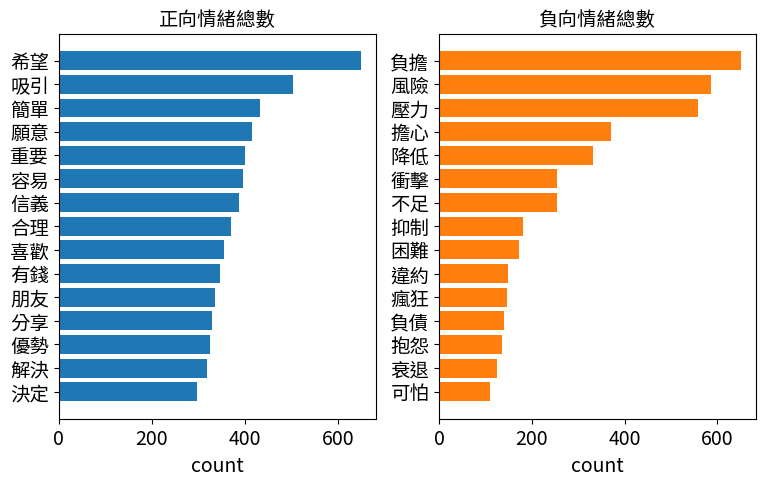

In [70]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()

word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2, figsize=(9,5))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

重新繪製情緒分數趨勢圖

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

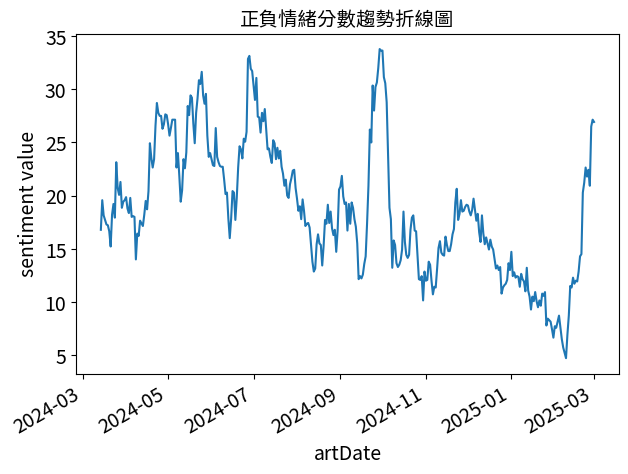

In [71]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots(figsize=(7,5))

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

### 3.8 2024-12 ~ 2025-02 文字雲

In [72]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
ptt_liwc_df_revise.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/home-sale/M.1709249161....  2024-03-01   
1  https://www.ptt.cc/bbs/home-sale/M.1709249161....  2024-03-01   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  2024-03-01   
3  https://www.ptt.cc/bbs/home-sale/M.1709249161....  2024-03-01   
4  https://www.ptt.cc/bbs/home-sale/M.1709249161....  2024-03-01   

                 artTitle                                         artContent  \
0  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  連結：\nhttps://money.udn.com/money/story/5621/78...   
1  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  連結：\nhttps://money.udn.com/money/story/5621/78...   
2  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  連結：\nhttps://money.udn.com/money/story/5621/78...   
3  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  連結：\nhttps://money.udn.com/money/story/5621/78...   
4  [新聞]台灣金聯：土地未運用有原因駁斥養地炒  連結：\nhttps://money.udn.com/money/story/5621/78...   

  word sentiments sentiment_class  
0   內文        NaN              正向  
1   台灣        NaN              正向  
2   金聯        NaN              正向  
3   土地        NaN              正向  
4   運用        NaN              正向

In [73]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head()

artUrl                artTitle  \
0  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
1  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
2  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
3  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   
4  https://www.ptt.cc/bbs/home-sale/M.1709249161....  [新聞]台灣金聯：土地未運用有原因駁斥養地炒   

               artDate                                         artContent  \
0  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
1  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
2  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
3  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   
4  2024-03-01 07:25:58  連結：\nhttps://money.udn.com/money/story/5621/78...   

                    sentence sentiment_class  
0                         連結              正向  
1                         內文              正向  
2       台灣金聯土地未運用有原因 駁斥養地炒房說              正向  
3                       媒體報導              正向  
4  具公股色彩的台灣金聯近年大舉在南台灣與建商競標土地              正向

In [74]:
date = "2024-12"
end_date = "2025-02"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc.head(10)

artUrl     artDate  \
678719  https://www.ptt.cc/bbs/home-sale/M.1733020102....  2024-12-01   
678720  https://www.ptt.cc/bbs/home-sale/M.1733020102....  2024-12-01   
678721  https://www.ptt.cc/bbs/home-sale/M.1733020102....  2024-12-01   
678722  https://www.ptt.cc/bbs/home-sale/M.1733020102....  2024-12-01   
678723  https://www.ptt.cc/bbs/home-sale/M.1733020102....  2024-12-01   
678724  https://www.ptt.cc/bbs/home-sale/M.1733020102....  2024-12-01   
678725  https://www.ptt.cc/bbs/home-sale/M.1733020102....  2024-12-01   
678726  https://www.ptt.cc/bbs/home-sale/M.1733020102....  2024-12-01   
678727  https://www.ptt.cc/bbs/home-sale/M.1733020102....  2024-12-01   
678728  https://www.ptt.cc/bbs/home-sale/M.1733020102....  2024-12-01   

                  artTitle                                         artContent  \
678719  Re:[情報]板南線新北段重劃區房價  較\n擠\n的\n讓\n經過了一個月，目前板南線新北段6個主要重劃區的過去一年均成交價格更新...   
678720  Re:[情報]板南線新北段重劃區房價  較\n擠\n的\n讓\n經過了一個月，目前板南線新北段6個主要重劃區的過去一年均成交價格更新...   
678721  Re:[情報]板南線新北段重劃區房價  較\n擠\n的\n讓\n經過了一個月，目前板南線新北段6個主要重劃區的過去一年均成交價格更新...   
678722  Re:[情報]板南線新北段重劃區房價  較\n擠\n的\n讓\n經過了一個月，目前板南線新北段6個主要重劃區的過去一年均成交價格更新...   
678723  Re:[情報]板南線新北段重劃區房價  較\n擠\n的\n讓\n經過了一個月，目前板南線新北段6個主要重劃區的過去一年均成交價格更新...   
678724  Re:[情報]板南線新北段重劃區房價  較\n擠\n的\n讓\n經過了一個月，目前板南線新北段6個主要重劃區的過去一年均成交價格更新...   
678725  Re:[情報]板南線新北段重劃區房價  較\n擠\n的\n讓\n經過了一個月，目前板南線新北段6個主要重劃區的過去一年均成交價格更新...   
678726  Re:[情報]板南線新北段重劃區房價  較\n擠\n的\n讓\n經過了一個月，目前板南線新北段6個主要重劃區的過去一年均成交價格更新...   
678727  Re:[情報]板南線新北段重劃區房價  較\n擠\n的\n讓\n經過了一個月，目前板南線新北段6個主要重劃區的過去一年均成交價格更新...   
678728  Re:[情報]板南線新北段重劃區房價  較\n擠\n的\n讓\n經過了一個月，目前板南線新北段6個主要重劃區的過去一年均成交價格更新...   

       word sentiments sentiment_class  
678719  板南線        NaN              負向  
678720   新北        NaN              負向  
678721   主要        NaN              負向  
678722  重劃區        NaN              負向  
678723   過去        NaN              負向  
678724   一年        NaN              負向  
678725   成交        NaN              負向  
678726   更新        NaN              負向  
678727   單一        NaN              負向  
678728   資料        NaN              負向

In [75]:
date = "2024-12"
end_date = "2025-02"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})

word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count.head(10)

word  size
4393   房價   537
4403   房市   204
2653   台灣   193
4418   房貸   161
7906   貸款   154
4399   房子   149
3148   壓力   147
8746   銀行   146
3867   市場   139
3374   央行   133

(-0.5, 1599.5, 799.5, -0.5)

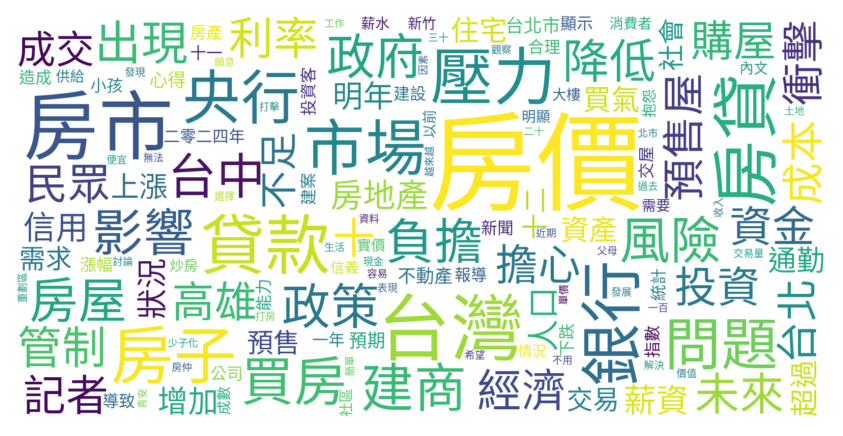

In [76]:
# wordcloud 的 input 是 dictionary
font_path = "./raw_data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(7, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

#### 關鍵字出現了「房價」、「房貸」、「壓力」、「負擔」的關鍵字，可能是在說明買房可能遇到的狀況

(-0.5, 1599.5, 799.5, -0.5)

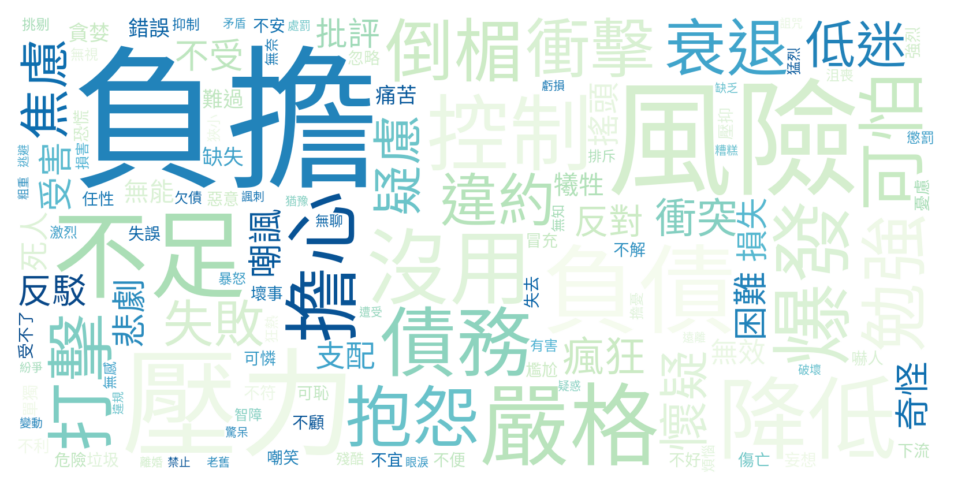

In [77]:
date = "2024-12"
end_date = "2025-02"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('房子')) & ( # 內文包含房子
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

#### 用「負擔」去察看原文

In [78]:
date = "2024-12"
end_date = "2025-02"
sent_df['artDate'] = pd.to_datetime(sent_df['artDate'], errors='coerce')

mask = (sent_df['artDate'] >= pd.Timestamp(date)) & (
    sent_df['artDate'] <= pd.Timestamp(end_date)) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('房子')) & (
    sent_df['sentence'].str.contains('負擔')) # 包含「負擔」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df[['artTitle', 'sentence', 'sentiment_class']].head(15)

artTitle               sentence sentiment_class
200751  Re:[心得]第一次買房心路歷程                原PO五年還清              負向
200752  Re:[心得]第一次買房心路歷程        意思也就是60個月還了200萬              負向
200753  Re:[心得]第一次買房心路歷程       平均每個月不算利息的話要還三萬多              負向
200754  Re:[心得]第一次買房心路歷程                我數學沒有很好              負向
200755  Re:[心得]第一次買房心路歷程            但當時基本薪資才一萬多              負向
200756  Re:[心得]第一次買房心路歷程      每個月可以負擔三萬多是真的蠻驚人的              負向
200757  Re:[心得]第一次買房心路歷程              我用房貸試算了一下              負向
200758  Re:[心得]第一次買房心路歷程               當時貸款200萬              負向
200759  Re:[心得]第一次買房心路歷程                  期間20年              負向
200760  Re:[心得]第一次買房心路歷程                  利率5的話              負向
200761  Re:[心得]第一次買房心路歷程         當時的銀行這樣子可以貸得過喔              負向
200788  Re:[心得]第一次買房心路歷程                  結果被嫌棄              負向
200789  Re:[心得]第一次買房心路歷程  重點是還能有很多人能夠很堅持地執行然後買房              負向
200790  Re:[心得]第一次買房心路歷程                  都非常厲害              負向
200791  Re:[心得]第一次買房心路歷程             原本的case結束了              負向

##### 可以看出文章中提到了，買房的人可能短期內需要承擔鉅額還款，以及房貸的條件過於嚴格，造成了買房的財務負擔。

# 使用中研院的CKIP自然語言處理工具包

In [79]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import re
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime

data_utils.download_data_gdown("./")  # 下載ckip model

Downloading...
From (original): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
From (redirected): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771&confirm=t&uuid=4cbb7f91-9ae4-43c2-bbfa-e9b7eb1f72c7
To: c:\Users\User\Desktop\2025-SMA-Study-Group-8\data.zip
100%|██████████| 1.88G/1.88G [00:44<00:00, 42.0MB/s]


In [80]:
# 將三份工具的模型路徑指向我們剛才下載的檔案「data」
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

c:\Users\User\anaconda3\envs\sa\Lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\User\anaconda3\envs\sa\Lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\User\anaconda3\envs\sa\Lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(h

讀取資料 & 資料清理

In [81]:
df = pd.read_csv('./raw_data/zh/ptt_house_price.csv')

def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    

    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)
    
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

CKIP 處理相關function

In [82]:
# 自定義辭典
with open('dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(2, {'公寓': 500.0, '華廈': 500.0, '套房': 500.0, '大樓': 500.0, '別墅': 500.0, '店面': 500.0, '房價': 500.0, '坪價': 500.0, '單價': 500.0, '總價': 500.0, '商圈': 500.0, '房貸': 500.0, '建坪': 500.0, '屋齡': 500.0}), (3, {'透天厝': 500.0, '樓中樓': 500.0, '辦公室': 500.0, '預售屋': 500.0, '重劃區': 500.0, '精華區': 500.0, '住宅區': 500.0, '工業區': 500.0, '商業區': 500.0, '月付金': 500.0, '不動產': 500.0, '建物稅': 500.0, '公設比': 500.0}), (4, {'電梯大樓': 599.0, '實價登錄': 500.0, '交易價格': 500.0, '買賣登記': 500.0, '履約保證': 500.0, '生活機能': 500.0, '交通便利': 500.0, '都市計畫': 500.0, '房貸利率': 500.0, '貸款成數': 500.0, '銀行貸款': 500.0, '租金補貼': 500.0, '租賃市場': 500.0, '使用坪數': 500.0, '室內坪數': 500.0, '格局方正': 500.0, '挑高設計': 500.0}), (5, {'房地合一稅': 500.0, '土地增值稅': 500.0}), (6, {'土地使用分區': 500.0})]


In [83]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [84]:
df['artContent'] = df['artContent'].astype(str)
#split("\n") 只能對 str 類型的變數使用，artContent某些欄位值可能為float

In [85]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 942.0822083950043


In [86]:
# 將文章存成csv
pos_table.to_csv('raw_data/zh/pos_table_ptt_house_price.csv', index = False)
entity_table.to_csv('raw_data/zh/entity_table_ptt_house_price.csv', index = False)
sentence_table.to_csv('raw_data/zh/sentence_table_ptt_house_price.csv', index = False)

In [87]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("raw_data/zh/pos_table_ptt_house_price.csv") 
entity_table = pd.read_csv("raw_data/zh/entity_table_ptt_house_price.csv") 
sentence_table = pd.read_csv("raw_data/zh/sentence_table_ptt_house_price.csv")

# NER

In [88]:
entity_table['ner'].unique()

array(['ORG', 'DATE', 'LOC', 'TIME', 'PERSON', 'CARDINAL', 'ORDINAL',
       'GPE', 'FAC', 'MONEY', 'NORP', 'WORK_OF_ART', 'QUANTITY', 'LAW',
       'LANGUAGE', 'PERCENT', 'EVENT', 'PRODUCT'], dtype=object)

In [89]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
ner_count

ner  count
4        GPE  26557
1       DATE  13574
13    PERSON  10446
11       ORG  10349
0   CARDINAL   9927
3        FAC   4254
7        LOC   4114
8      MONEY   3988
10   ORDINAL   2654
9       NORP   1577

Text(0.5, 0, 'Frequency')

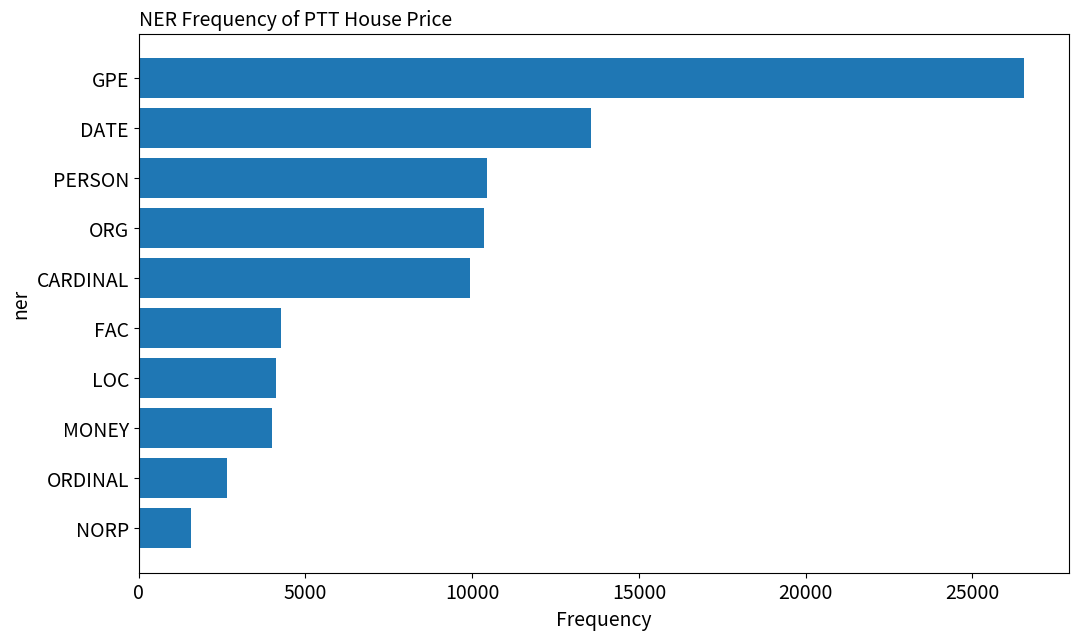

In [90]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT House Price',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
# fig.show()

# 涉及到的民族

Text(0.5, 0, 'Word Frequency')

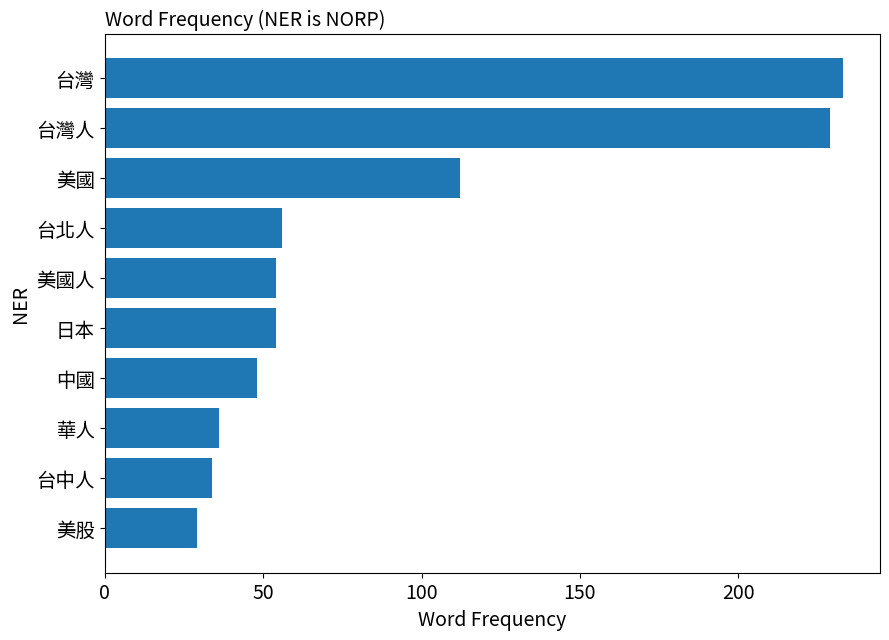

In [91]:
# 篩選ner為NORP的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

台灣的房價常常與美國、中國、日本互相比較。其中台灣被討論最多的區域為台北和台中。

# 涉及到的組織

Text(0.5, 0, 'Word Frequency')

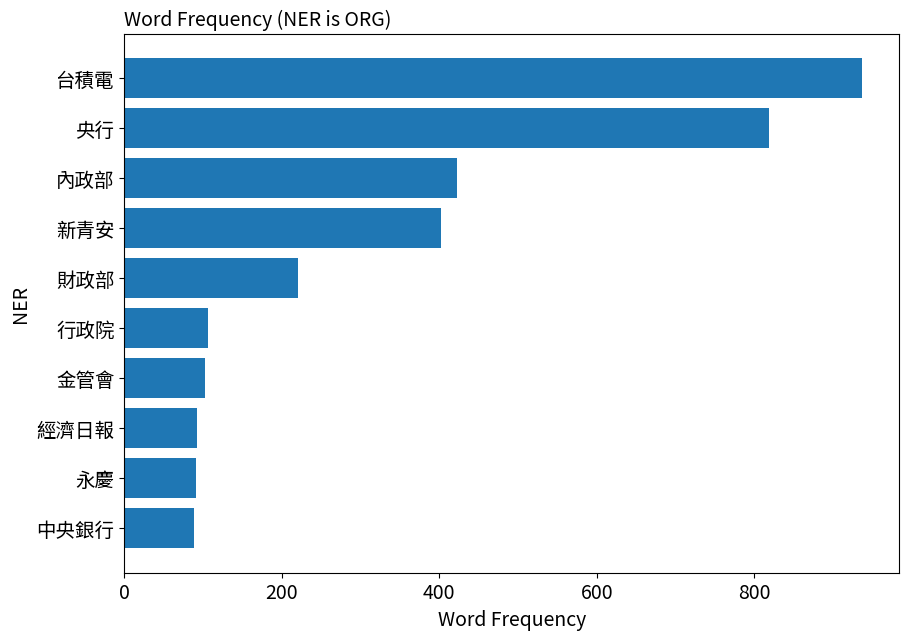

In [92]:
# 篩選ner為ORG的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

談到房價時，台積電常常被提及，可能與股價有關係。
央行、內政部、新青安提出的政策是大家關注的焦點。

# 涉及到的人名

Text(0.5, 0, 'Word Frequency')

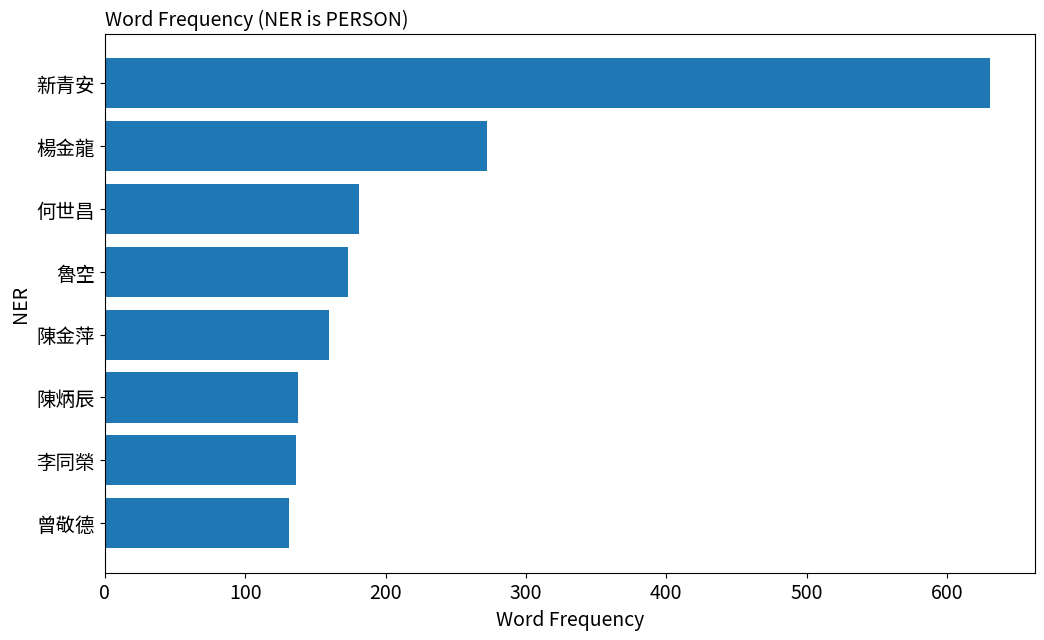

In [93]:
# 篩選ner為PERSON的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

以上人名包含政府高官及房市分析師，楊金龍(央行總裁)、陳金萍(永慶房屋研展中心副理)、何世昌(房市分析師)。

# 找出「新青安」相關文章，與後續情緒分析一起做探索

In [94]:
keyword_list = ['新青安']
shu_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{shu_selected.shape[0]}篇相關貼文")
shu_selected.head(3)

新青安：749篇相關貼文


system_id                                             artUrl  \
8           9  https://www.ptt.cc/bbs/home-sale/M.1709272677....   
10         11  https://www.ptt.cc/bbs/home-sale/M.1709289053....   
17         18  https://www.ptt.cc/bbs/home-sale/M.1709364873....   

                      artTitle              artDate  artPoster artCatagory  \
8   [新聞]月收72K想買988萬新成屋　過來人警1事：  2024-03-01 13:57:55  enouch777   home_sale   
10    [新聞]打房氛圍消散　前2月買賣移轉棟數創13年  2024-03-01 18:30:51  TyuzuChou   home_sale   
17     [新聞]「買房免還完房貸」開戰！少子化誰接手吵  2024-03-02 15:34:31    lienchi   home_sale   

                                           artContent  \
8   連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...   
10  連結：\nhttps://house.ettoday.net/news/2691986\n內...   
17  連結：\nhttps://reurl.cc/N4gKQ9\n內文：購屋族流傳「買房不用還完房...   

                                           artComment             e_ip  \
8   [{"cmtStatus": "→", "cmtPoster": "eulbos", "cm...  101.137.147.220   
10  [{"cmtStatus": "推", "cmtPoster": "qwqwasas", "...    101.0.232.170   
17  [{"cmtStatus": "→", "cmtPoster": "chris44099",...  220.132.207.203   

           insertedDate dataSource  
8   2024-03-02 01:42:39        ptt  
10  2024-03-02 01:42:39        ptt  
17  2024-03-03 01:43:48        ptt

# POS分析

In [95]:
pos_table['pos'].unique()

array(['VC', 'FW', 'Na', 'Nc', 'Nb', 'D', 'V_2', 'VE', 'COMMACATEGORY',
       'VJ', 'DE', 'Nd', 'P', 'Ncd', 'Caa', 'VH', 'Ng', 'Neu', 'Nf', 'VA',
       'VD', 'SHI', 'Cbb', 'Nes', 'VG', 'VHC', 'Nh', 'A', 'Neqa', 'VB',
       'VCL', 'Nep', 'VL', 'VK', 'VAC', 'Dfa', 'Di', 'T', 'Da', 'Cba',
       'Nv', 'DM', 'VI', 'Dk', 'VF', 'Cab', 'Dfb', 'I', 'Neqb',
       'COLONCATEGORY', 'PERIODCATEGORY', 'PARENTHESISCATEGORY',
       'ETCCATEGORY'], dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [96]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

pos   count
16   Na  310837
5     D  171277
42   VH  100306
36   VC   98474
18   Nc   88856
6    DE   56032
30    P   49463
26   Nf   40742
4   Cbb   36214
33   VA   36039
39   VE   34089
28   Nh   30438

C:\Users\User\AppData\Local\Temp\ipykernel_2468\2478466374.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


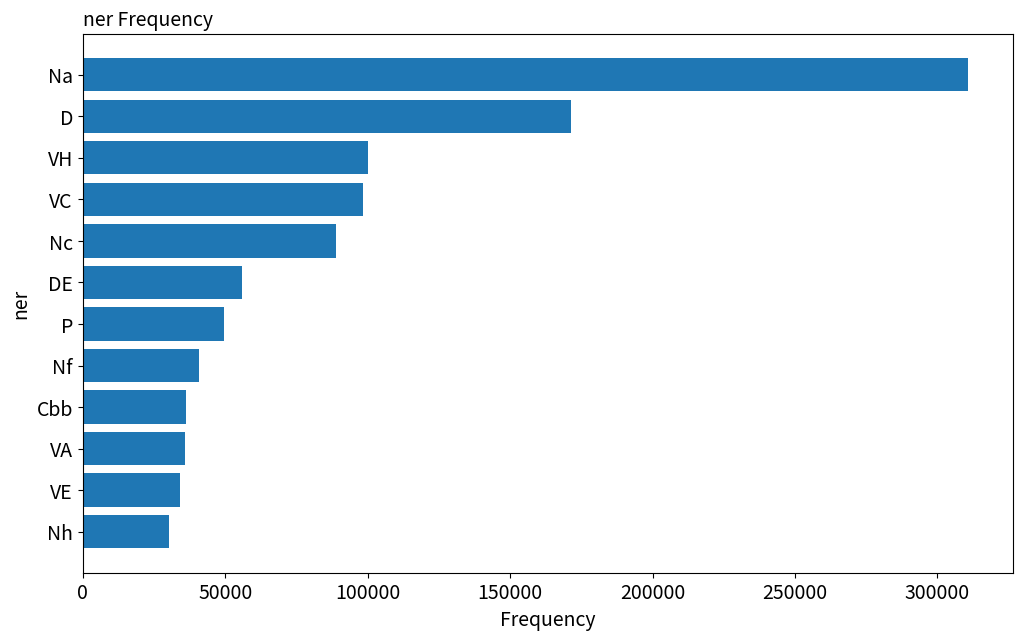

In [97]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

# 涉及到的名詞(Noun)

In [98]:
# 篩選pos為專有名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

word  count
1923   新青安   1155
654    台積電   1101
2602    永慶    346
2483   楊金龍    272
4814    魯空    211
243    何世昌    182
3246  經濟日報    165
4578   陳金萍    160
1291    小白    143
4549   陳炳辰    138

C:\Users\User\AppData\Local\Temp\ipykernel_2468\488784228.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


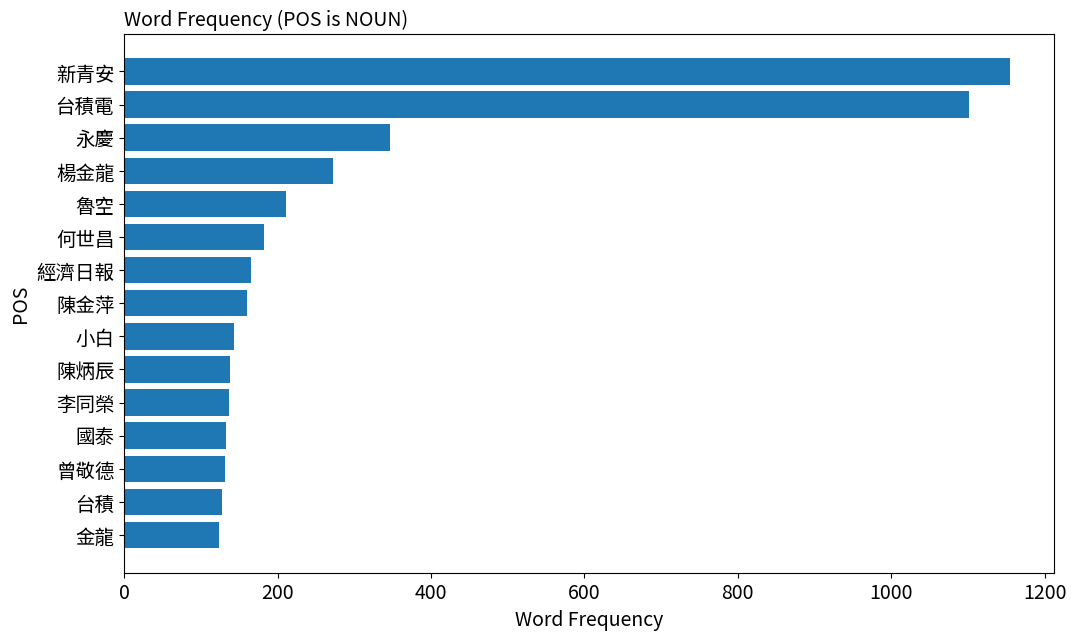

In [99]:
# 設定中文字形
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

新青安依舊為討論度最高的專有名詞。台積電與永慶房屋也是大家關注的焦點(推測股市可能影響房市)。

# 涉及到的動詞(VERB)

In [100]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

word  count
2080   投資   1381
3925   發展   1027
5575   連結   1020
1782   影響    867
1616   帶動    702
532    分析    583
2525   推出    564
5102   負擔    548
5676   選擇    522
5877   開發    497
4828   規劃    470
5230   賣掉    406
5595   進行    360
5792   銷售    351
4755   表現    349

C:\Users\User\AppData\Local\Temp\ipykernel_2468\29217454.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


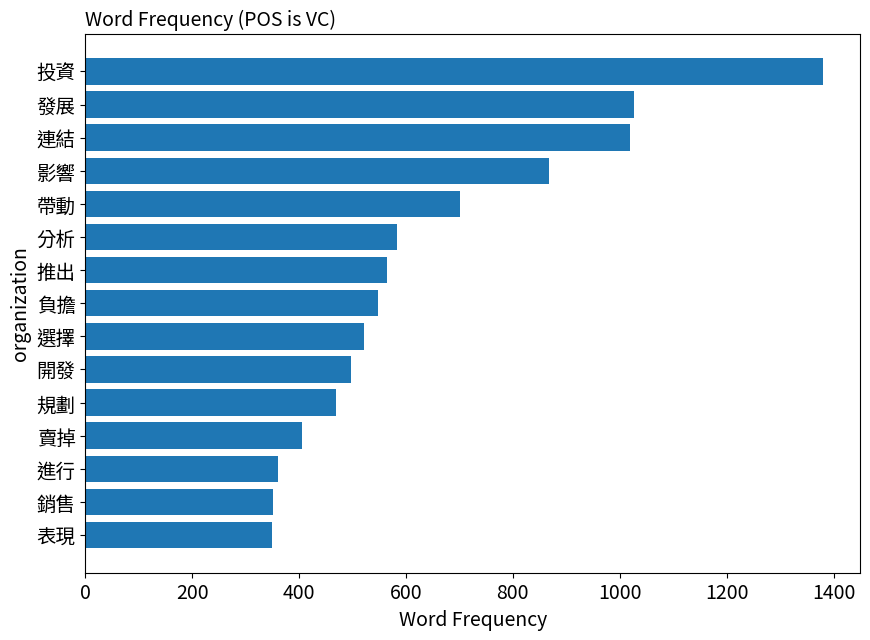

In [101]:
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is VC)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

大家對投資房方面較有興趣。對房市的發展及影響有較高的重視程度。

# 利用SnowNLP進行情緒分析

使用先前NER得到的「新青安」相關文章，看看旭集相關文章的情緒表現。<br>
首先將句子和日期合併，方便之後做分析

In [102]:
sentence_table = pd.read_csv("raw_data/zh/sentence_table_ptt_house_price.csv") #匯資料

sentiment_date = pd.merge(sentence_table,shu_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head(3)

system_id                sentence              artDate dataSource
203          9                      連結  2024-03-01 13:57:55        ptt
204          9                     ///  2024-03-01 13:57:55        ptt
205          9  內文月收想買萬新成屋過來人警事房貸比房東無情  2024-03-01 13:57:55        ptt

In [103]:
from snownlp import SnowNLP
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

system_id                sentence              artDate dataSource  \
203          9                      連結  2024-03-01 13:57:55        ptt   
204          9                     ///  2024-03-01 13:57:55        ptt   
205          9  內文月收想買萬新成屋過來人警事房貸比房東無情  2024-03-01 13:57:55        ptt   

     sentimentValue  
203        0.536507  
204        0.250000  
205        0.007152

In [104]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    2.847500e+04
mean     3.648147e-01
std      3.149885e-01
min      3.119061e-12
25%      6.396040e-02
50%      2.935473e-01
75%      5.957941e-01
max      9.999991e-01
Name: sentimentValue, dtype: float64

<Axes: >

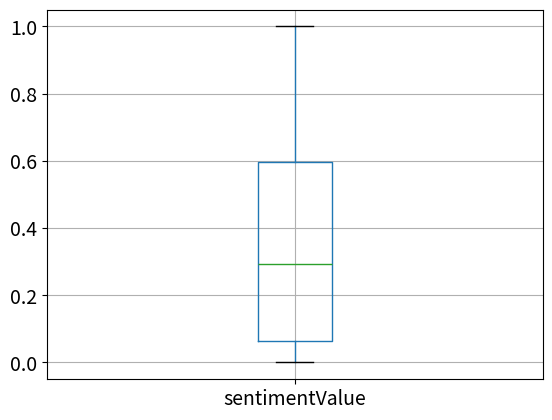

In [105]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

將每個月的情緒分數取平均，並轉換時間格式為年月

In [106]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

artDate  sentimentValue
0   2024-03        0.357877
1   2024-04        0.389025
2   2024-05        0.369385
3   2024-06        0.371648
4   2024-07        0.368352
5   2024-08        0.349792
6   2024-09        0.356263
7   2024-10        0.367935
8   2024-11        0.354343
9   2024-12        0.373301
10  2025-01        0.360342
11  2025-02        0.381348

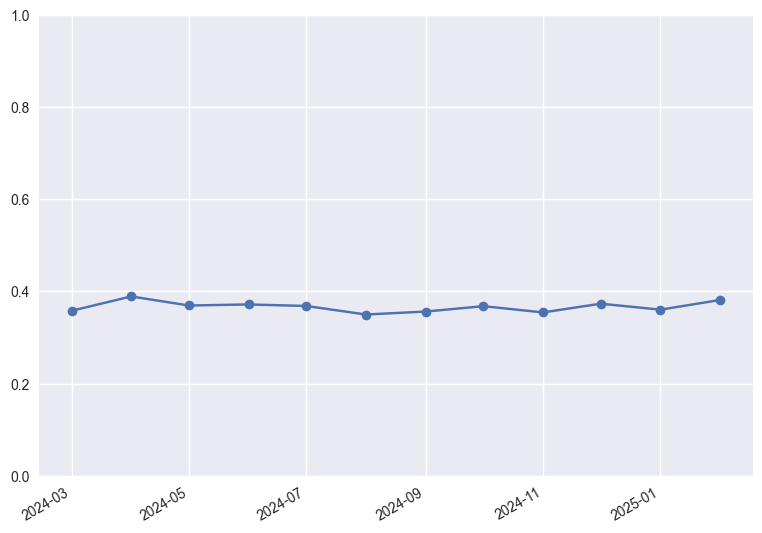

In [107]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn-v0_8')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

從上圖中發現大部分天數的情緒值都在0.3~0.4之間，偏向負面，PTT房屋板上多數人不滿現在的房價。我們挑出 2024年11月 來分析。

# 詞彙探索
從上圖中可以發現 2024年11月 的情緒分數相對低，我們把這個月的負面句子挑出來看看他們都用甚麼詞。

In [108]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2024-11']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.4]

filter_sentiment.head()

system_id                               sentence  artDate dataSource  \
111523       3948                          內文月房市交易較月高點腰斬  2024-11        ptt   
111525       3948  受到銀行房貸緊縮與第七波選擇性信用管制的影響，房市買氣連四降，月交易量量縮  2024-11        ptt   
111527       3948          新竹縣市量縮台中略減，台南與高雄分別月減與，顯示月交易量已  2024-11        ptt   
111529       3948    房市交易相較年月同期，永慶房屋研展中心副理陳金萍說明，全台房市交易量年  2024-11        ptt   
111530       3948               減，台北年減新北量縮桃園年減新竹縣市減少台中年減  2024-11        ptt   

        sentimentValue  
111523        0.086576  
111525        0.000750  
111527        0.028581  
111529        0.027060  
111530        0.147019

In [109]:
# 把時間分數和之前斷詞的 token table 做 join
pos_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

system_id  sentimentValue     word
0       3948        0.086576       連結
1       3948        0.086576  ///////
2       3948        0.086576      內文月
3       3948        0.086576       房市
4       3948        0.086576       交易

In [110]:
# 篩選掉只有單個字元的結果
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]

# 負面詞彙文字雲

In [111]:
# 自定停用字
with open('dict/stop_words.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words[:20])

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '可否', '有無', '再', '本來', '是不是', '一個', '這種']


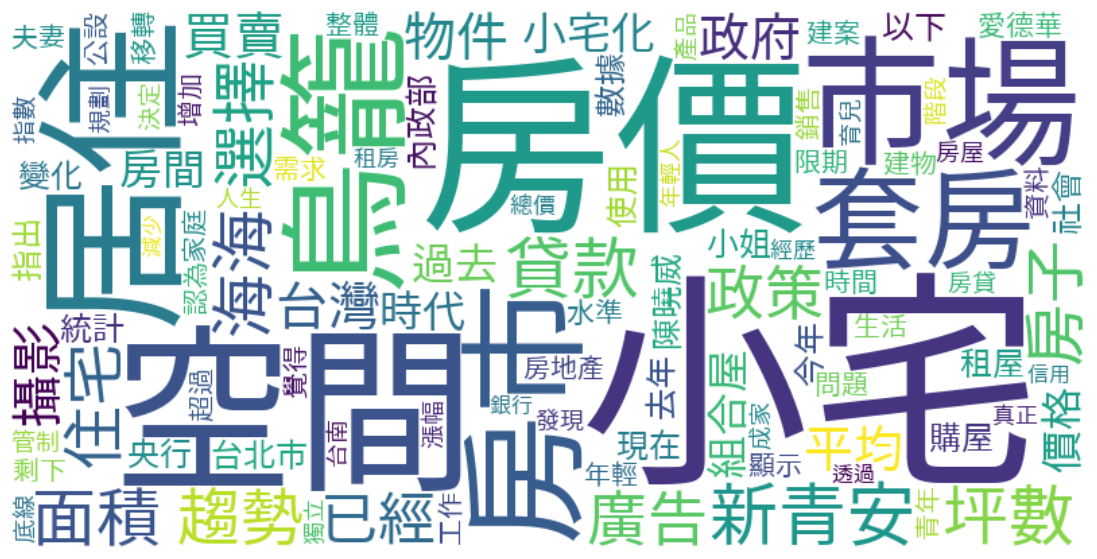

In [112]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('成為','第二','出現','愈來愈','正好','影響','鯨魚'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

透過「小宅」、「空間」、「鳥籠」、「面積」，可得知多數文章對房屋的大小很有意見。在討論房價及房市時，政府單位及政策也是多數文章會提及的詞彙。

# 遇到的困難和解決方式
1. 資料前處理時，使用範例程式碼時，可能會連帶文章內容一起被移除。  
原本範例程式碼先將\n換成逗號，\n\n換成句號，接著才做移除網址。     
導致正則表達式'http\S+'匹配不到換行符號，連帶將後面的字也一起移除。    
解決方式: 改變順序    
先做移除網址，才將\n換成逗號，\n\n換成句號，讓移除網址時可以讀到換行符號，就不會連後面的文字一同移除。 
2. 在做情緒分析時，原本未將時間移除  
導致畫出來的圖看起來較密集  
解決方式: 將時間移除   
2024-03-01  07:25:58 ⭢ 2024-03-01 